# Air Quality Analysis in Beijing


### Data source: Beijing Multi-Site Air Quality Data
### Available at: https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy import stats

In [39]:
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

## 1. Data Collection

In [40]:
data_file = "Beijing_Multisite_air_Quality_data.csv"
data_df = pd.read_csv(data_file)
data_df.head()

year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  WSPM       station
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0    N   2.0  Aotizhongxin

In [41]:
print(f"DataFrame Shape: {data_df.shape}\n")
data_df.info()

DataFrame Shape: (420768, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 54.6+ MB


In [42]:
numeric_columns = data_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = data_df.select_dtypes(include=['object']).columns.tolist()

print(f"{len(numeric_columns)} Numeric columns: {numeric_columns}")
print(f"{len(categorical_columns)} Categorical columns: {categorical_columns}")


15 Numeric columns: ['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
2 Categorical columns: ['wd', 'station']


### Let's check the distribution of the dataset among different stations.


In [43]:
data_df.groupby('station').size().reset_index(name='row_count')

station  row_count
0    Aotizhongxin      35064
1       Changping      35064
2        Dingling      35064
3          Dongsi      35064
4        Guanyuan      35064
5         Gucheng      35064
6         Huairou      35064
7    Nongzhanguan      35064
8          Shunyi      35064
9         Tiantan      35064
10         Wanliu      35064
11  Wanshouxigong      35064

### Since all stations have the same number of data points, we select only the first two stations, Aotizhongxin and Changping, for further analysis.

In [57]:
filtered_df = data_df[data_df['station'].isin(['Aotizhongxin', 'Changping'])]
print(f'Dataframe Shape: {filtered_df.shape}')
filtered_df.head()

Dataframe Shape: (70128, 17)


year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  WSPM       station
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0    N   2.0  Aotizhongxin

## 2. Data Cleaning

### Create a timestamp column

In [58]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df[['year', 'month', 'day', 'hour']])
filtered_df['day_name'] = filtered_df['timestamp'].dt.day_name()
filtered_df['month_name'] = filtered_df['timestamp'].dt.month_name()

In [86]:
print(f"The data for Aotizhongxin station is {'sorted' if filtered_df[filtered_df.station == 'Aotizhongxin']['timestamp'].is_monotonic_increasing else 'not sorted'} by timestamp.")
print(f"The data for Changping station is {'sorted' if filtered_df[filtered_df.station == 'Changping']['timestamp'].is_monotonic_increasing else 'not sorted'} by timestamp.")


The data for Aotizhongxin station is sorted by timestamp.
The data for Changping station is sorted by timestamp.


### Check for Duplicate Entries

In [59]:
duplicate_count = filtered_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### Removing non-pollutant columns 

In [60]:
filtered_df.drop(columns=['TEMP','PRES','DEWP','RAIN','wd','WSPM'], inplace=True)

In [61]:
print(f'Dataframe Shape: {filtered_df.shape}')

filtered_numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
filtere_categorical_columns = filtered_df.select_dtypes(include=['object']).columns.tolist()

print(f"{len(filtered_numeric_columns)} Numeric columns: {filtered_numeric_columns}")
print(f"{len(filtere_categorical_columns)} Categorical columns: {filtere_categorical_columns}")

Dataframe Shape: (70128, 14)
10 Numeric columns: ['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
3 Categorical columns: ['station', 'day_name', 'month_name']


### Let's Check if there are any missing values in the filtered dataset.

In [62]:
filtered_df.isnull().sum()

year             0
month            0
day              0
hour             0
PM2.5         1699
PM10          1300
SO2           1563
NO2           1690
CO            3297
O3            2323
station          0
timestamp        0
day_name         0
month_name       0
dtype: int64

### Calculating mean and median differences to assess data distribution for handling missing values.

In [63]:
numerical_filtered_df = filtered_df.select_dtypes(include=['number'])
mean_median_diff = numerical_filtered_df.mean() - numerical_filtered_df.median()
print("Differences between Mean and Median\n", mean_median_diff)

Differences between Mean and Median
 year      -0.337440
month     -0.477070
day       -0.270363
hour       0.000000
PM2.5     24.923797
PM10      23.343914
SO2        8.161992
NO2        7.704624
CO       407.412159
O3        12.159726
dtype: float64


### Mean values greater than medians for PM2.5, PM10, SO2, NO2, CO, and O3 indicate a right-skewed distribution.

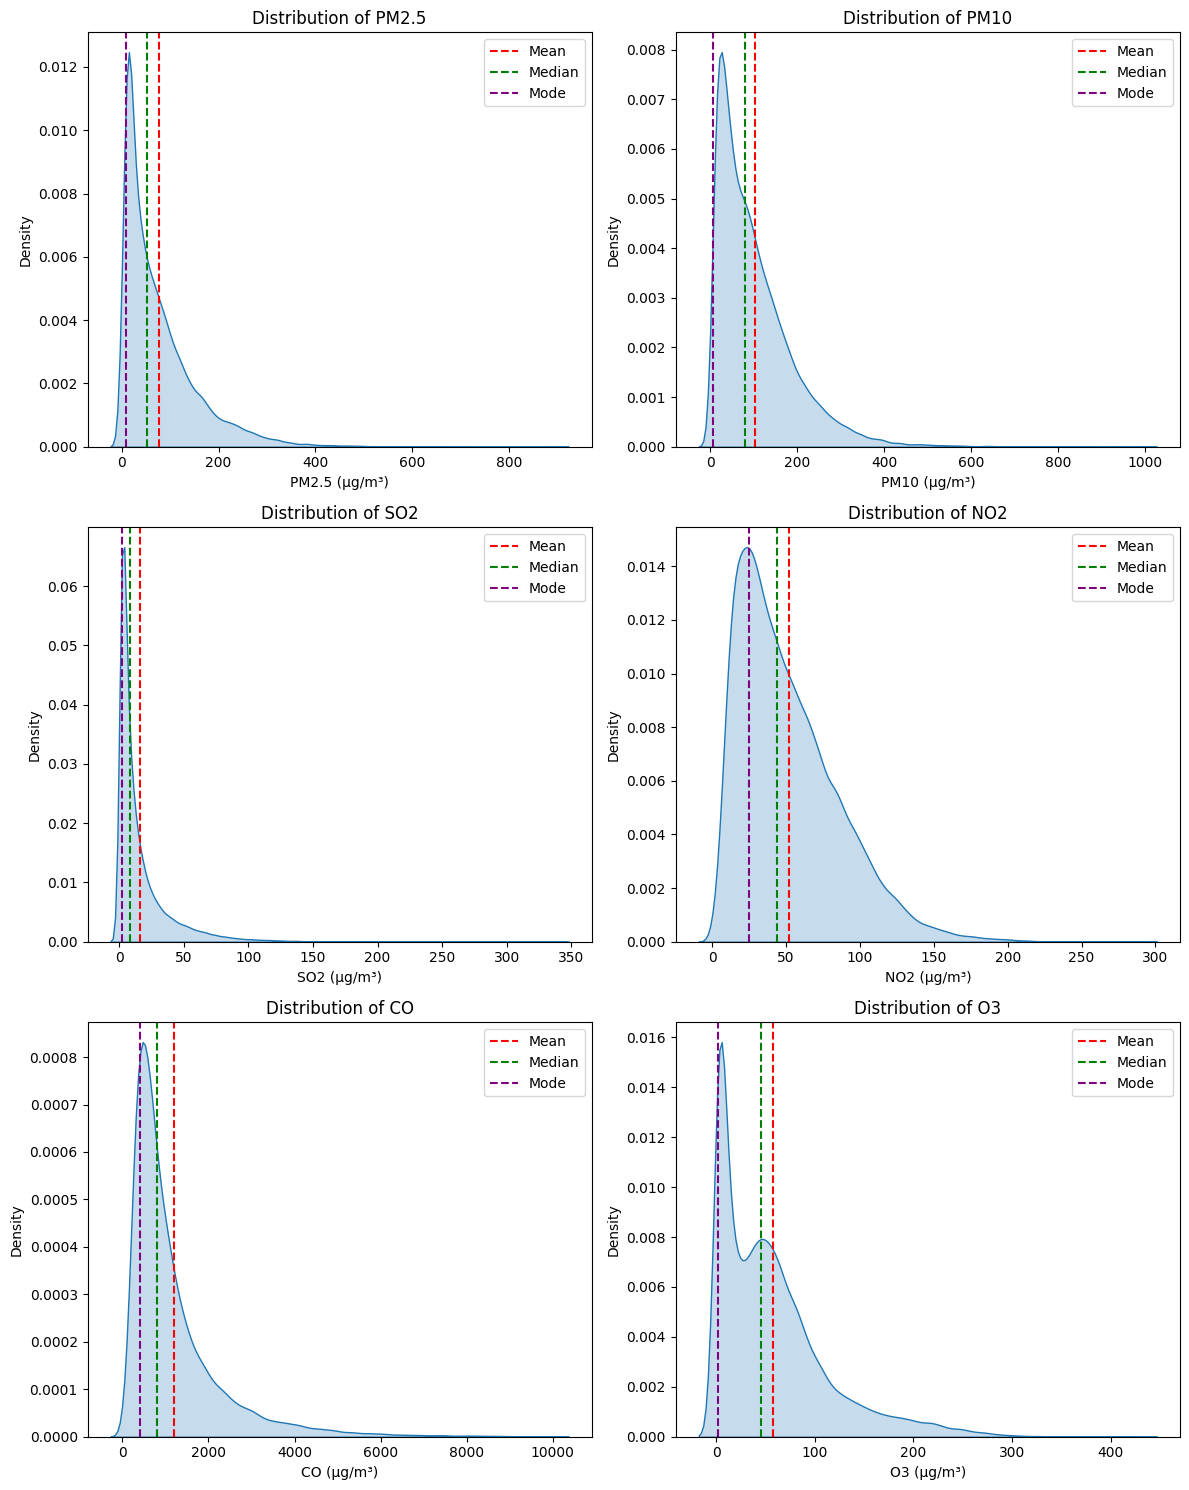

In [64]:
mode = numerical_filtered_df.mode().iloc[0]
mean = numerical_filtered_df.mean()
median = numerical_filtered_df.median()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))  
axes = axes.flatten()

parameters = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

for i, column in enumerate(parameters):
    sns.kdeplot(numerical_filtered_df[column], fill=True, ax=axes[i])
    axes[i].axvline(x=mean[column], color='red', linestyle='--', label='Mean')
    axes[i].axvline(x=median[column], color='green', linestyle='--', label='Median')
    axes[i].axvline(x=mode[column], color='purple', linestyle='--', label='Mode')
    axes[i].set_xlabel(f'{column} (µg/m³)')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Imputing Missing Values: filling with median as it is less influenced by outliers compared to the mean.

In [65]:
filtered_df.fillna({
    'PM2.5': filtered_df['PM2.5'].median(),
    'PM10': filtered_df['PM10'].median(),
    'SO2': filtered_df['SO2'].median(),
    'NO2': filtered_df['NO2'].median(),
    'CO': filtered_df['CO'].median(),
    'O3': filtered_df['O3'].median()
}, inplace=True)

### Outliers
### Identifying outliers of pollutants using the IQR method

In [66]:
outliers_percentage = {}

for pollutant in parameters:

    Q1 = filtered_df[pollutant].quantile(0.25)
    Q3 = filtered_df[pollutant].quantile(0.75)
    
    # Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define outliers: below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = filtered_df[(filtered_df[pollutant] < lower_bound) | (filtered_df[pollutant] > upper_bound)]
    
    outliers_percentage[pollutant] = (len(outliers) / len(filtered_df)) * 100

for pollutant, percentage in outliers_percentage.items():
    print(f"{pollutant}: {percentage:.2f}% of values are outliers")


PM2.5: 5.07% of values are outliers
PM10: 3.62% of values are outliers
SO2: 9.48% of values are outliers
NO2: 1.84% of values are outliers
CO: 8.36% of values are outliers
O3: 4.60% of values are outliers


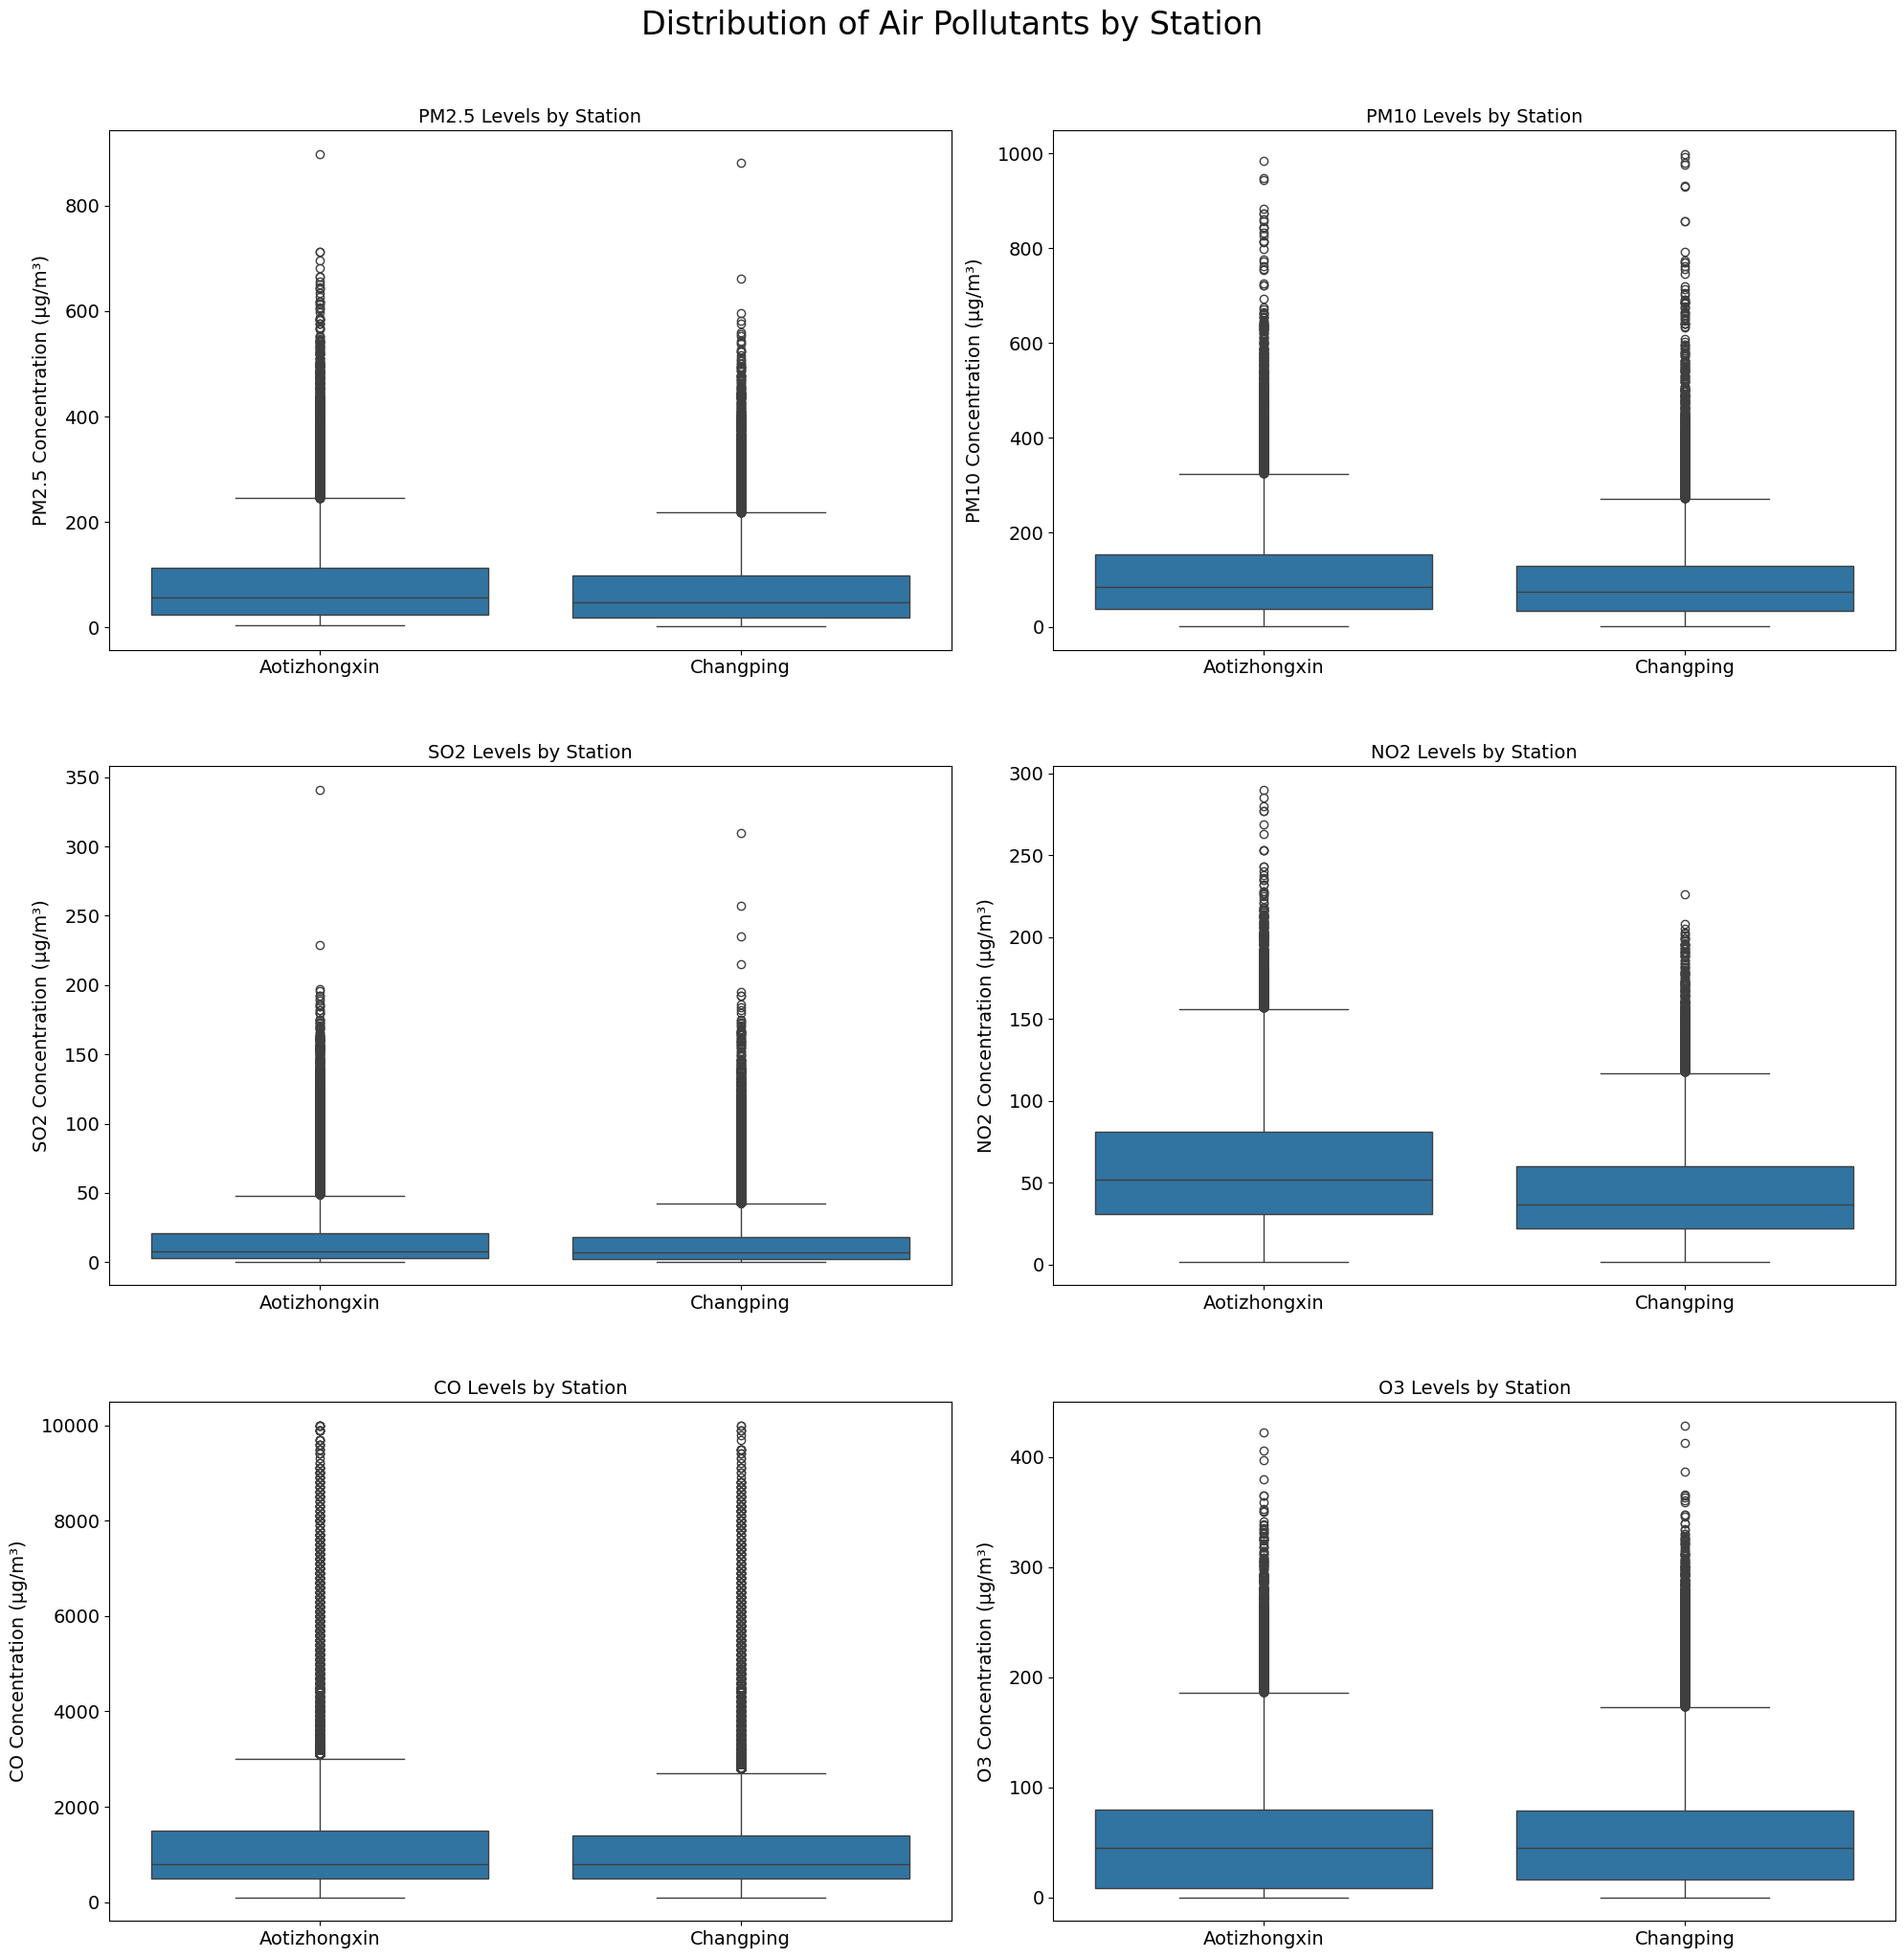

In [67]:
stations = filtered_df['station'].unique()

plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='station', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Station', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.suptitle('Distribution of Air Pollutants by Station', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()

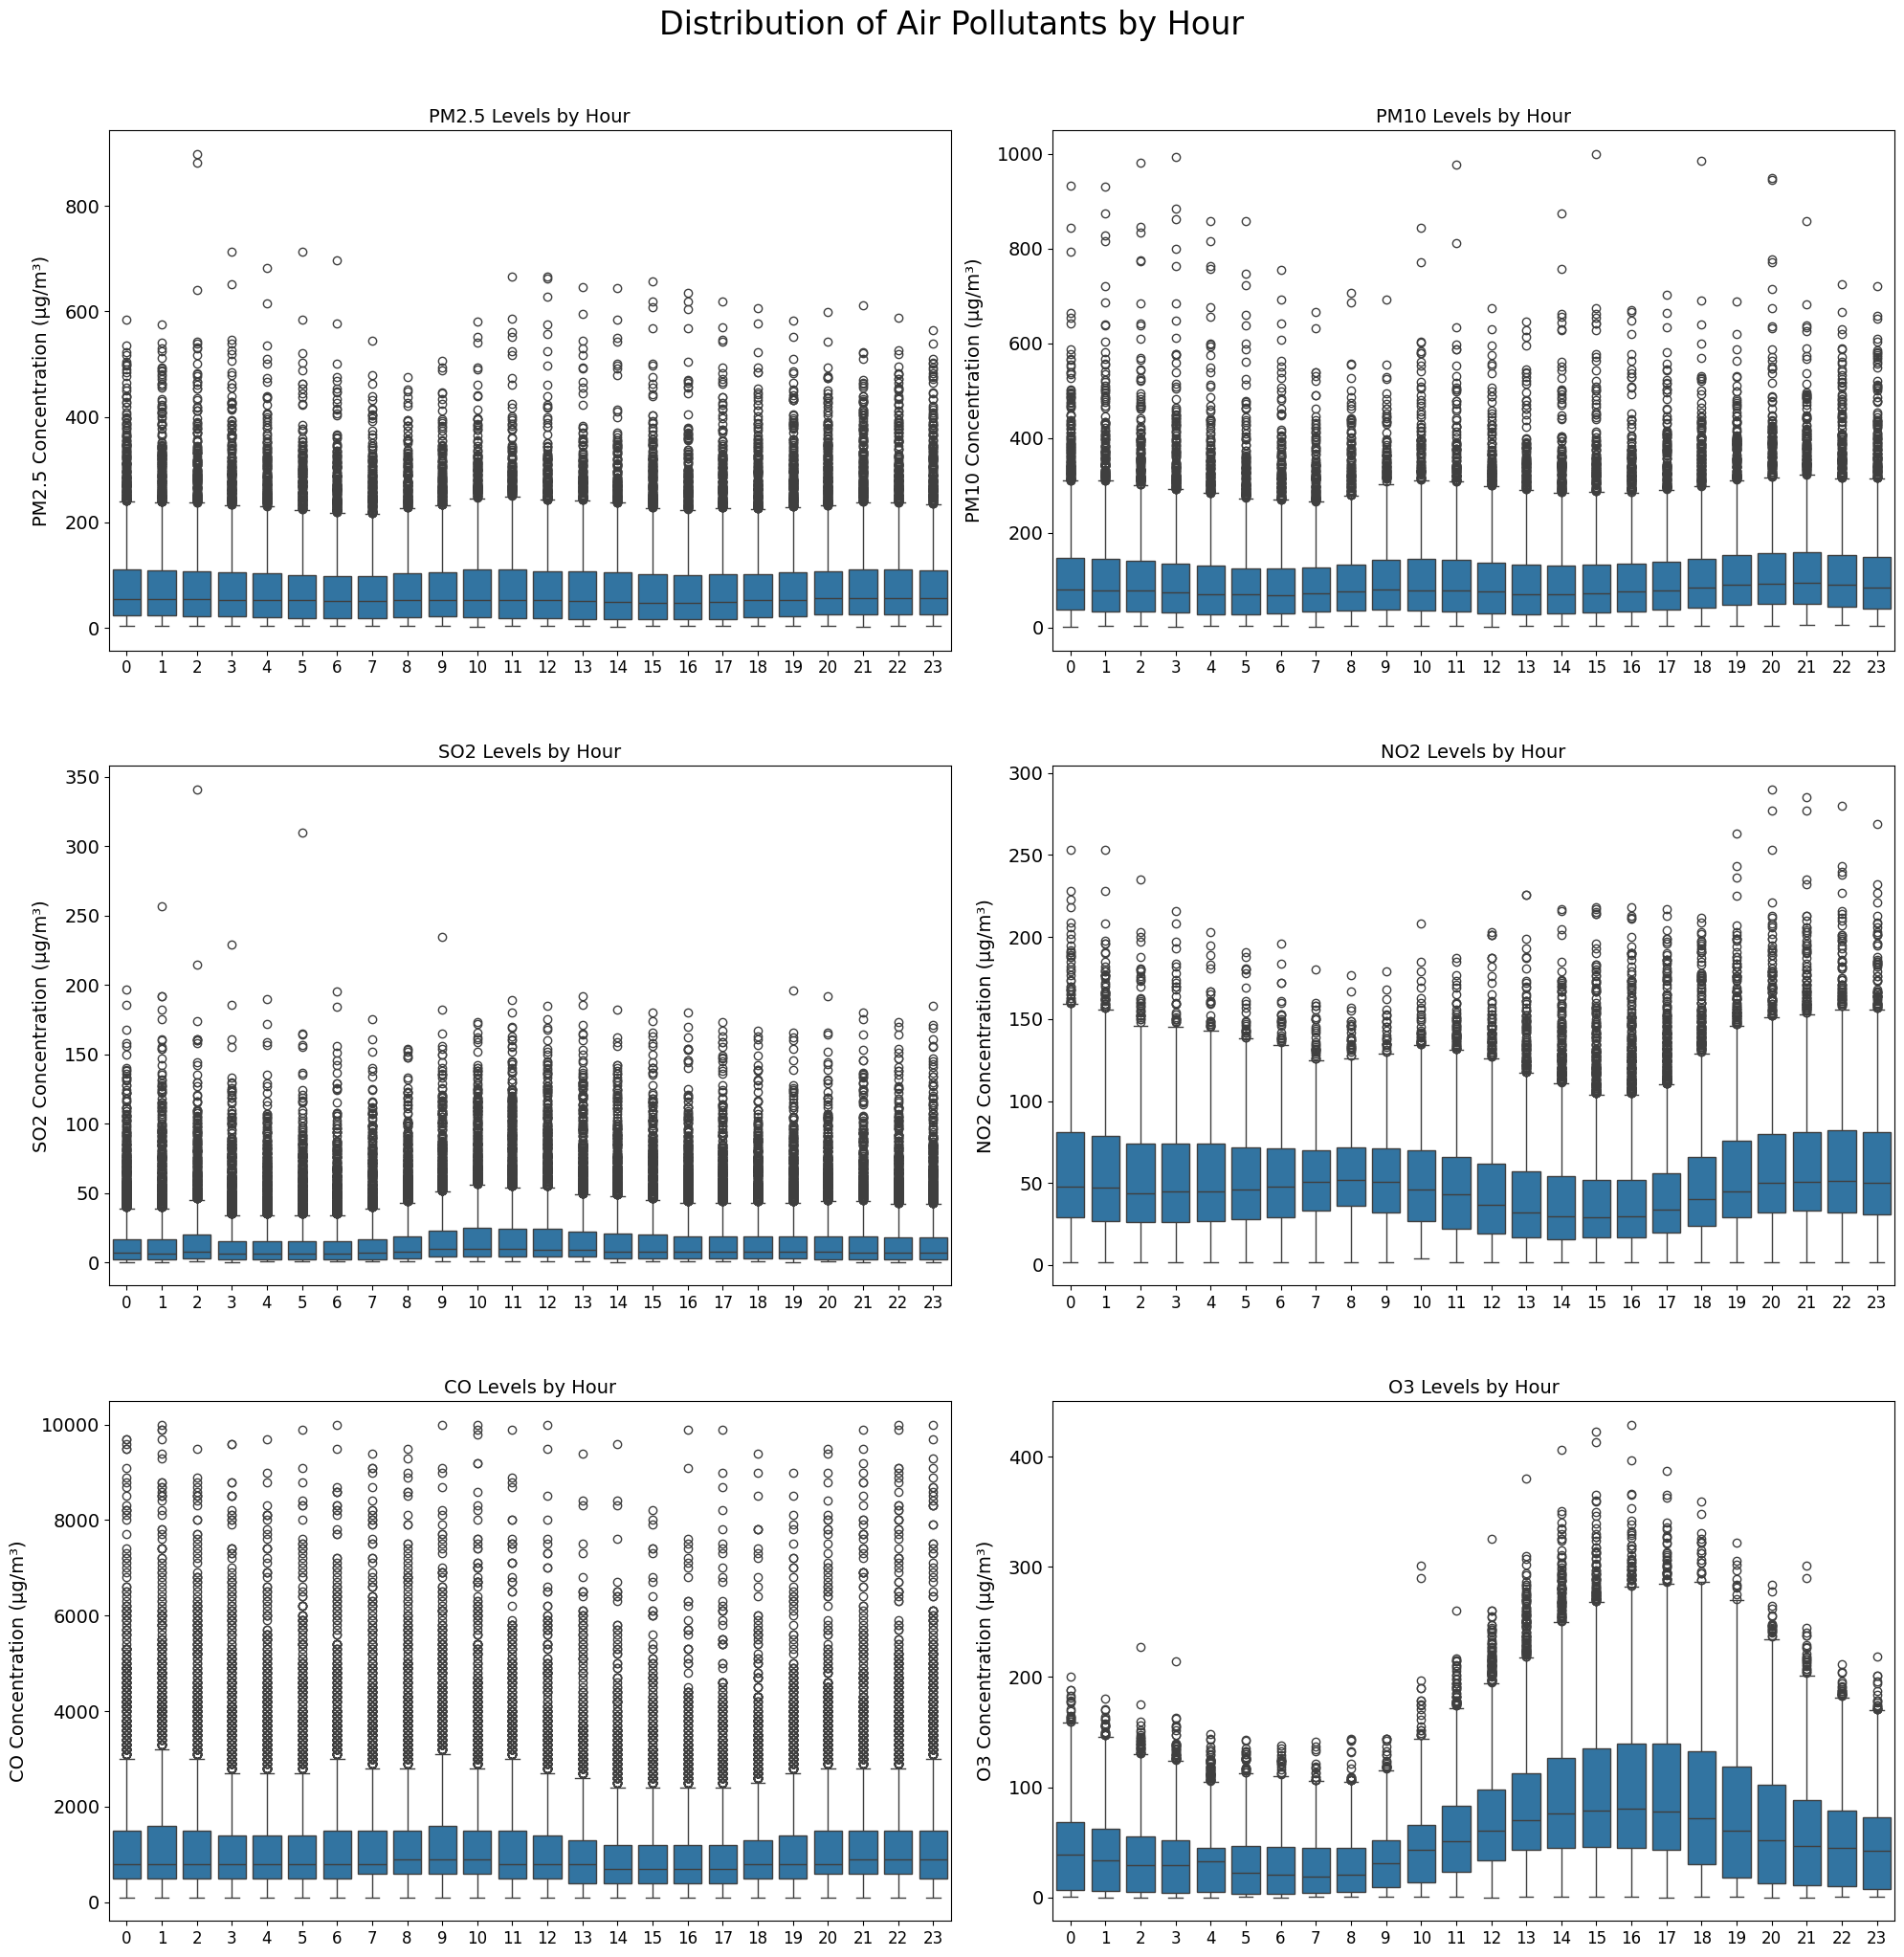

In [68]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='hour', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Hour', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Hour', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


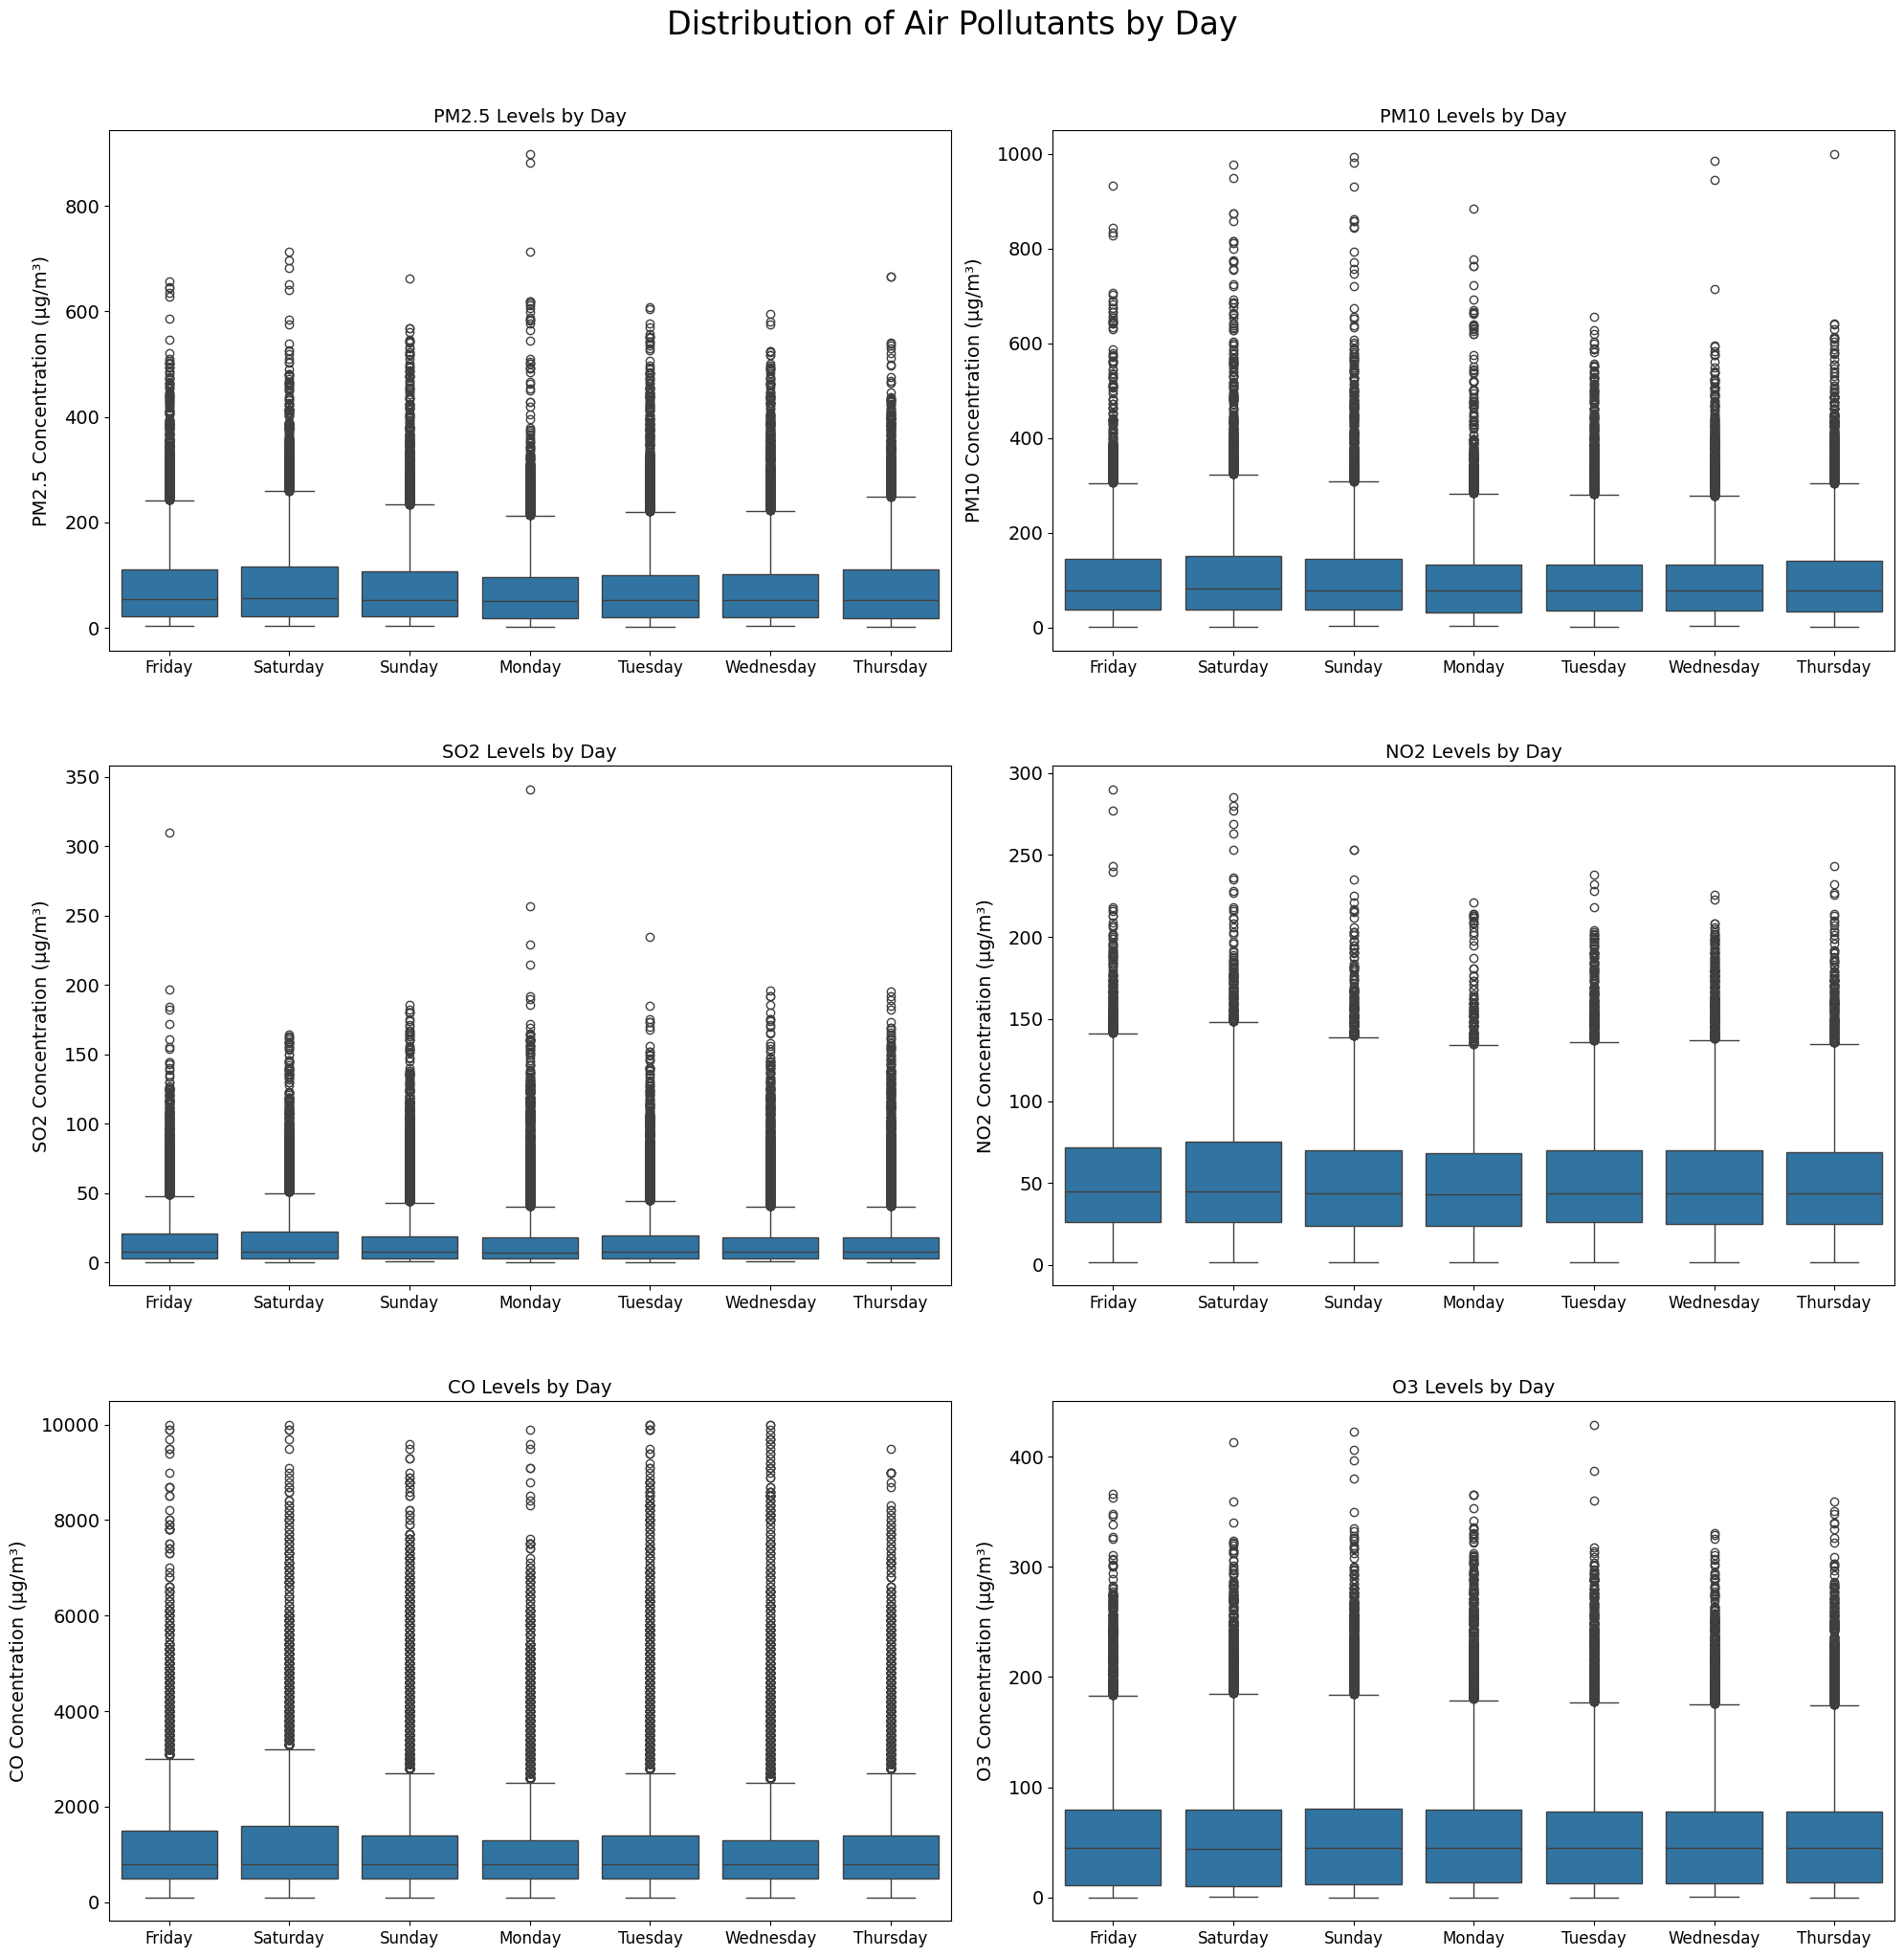

In [69]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='day_name', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Day', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Day', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


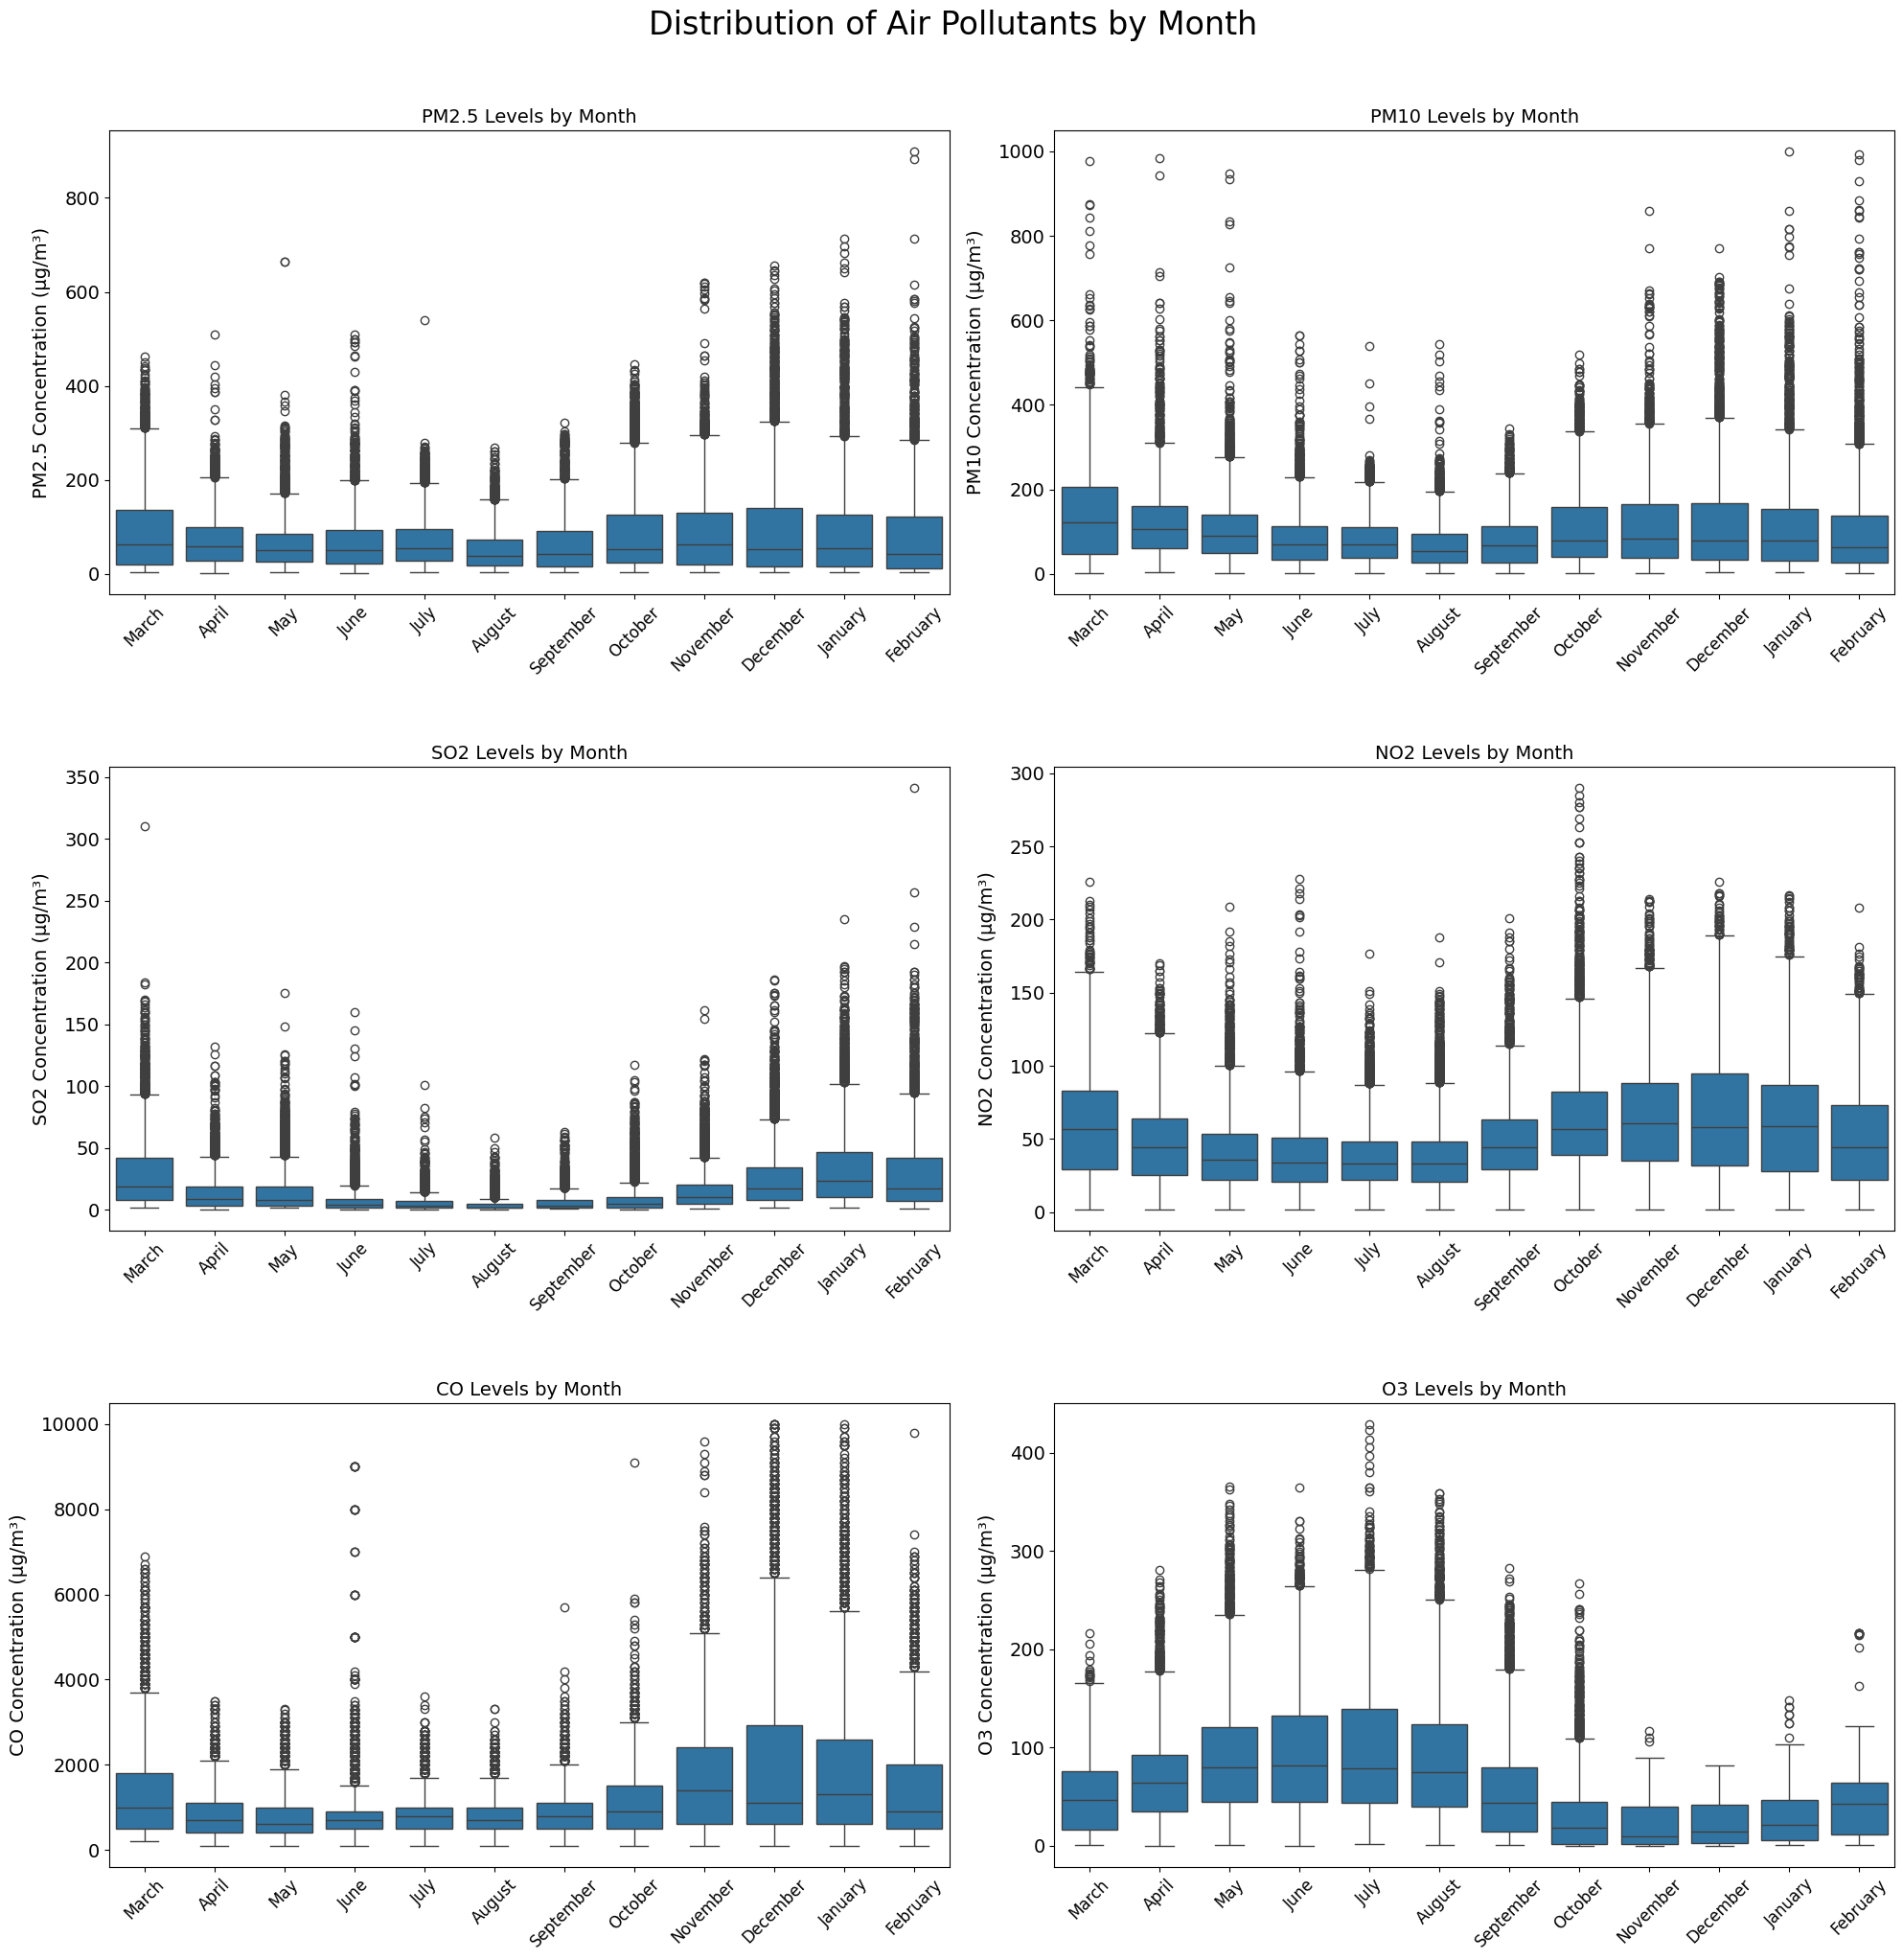

In [70]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='month_name', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Month', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Month', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


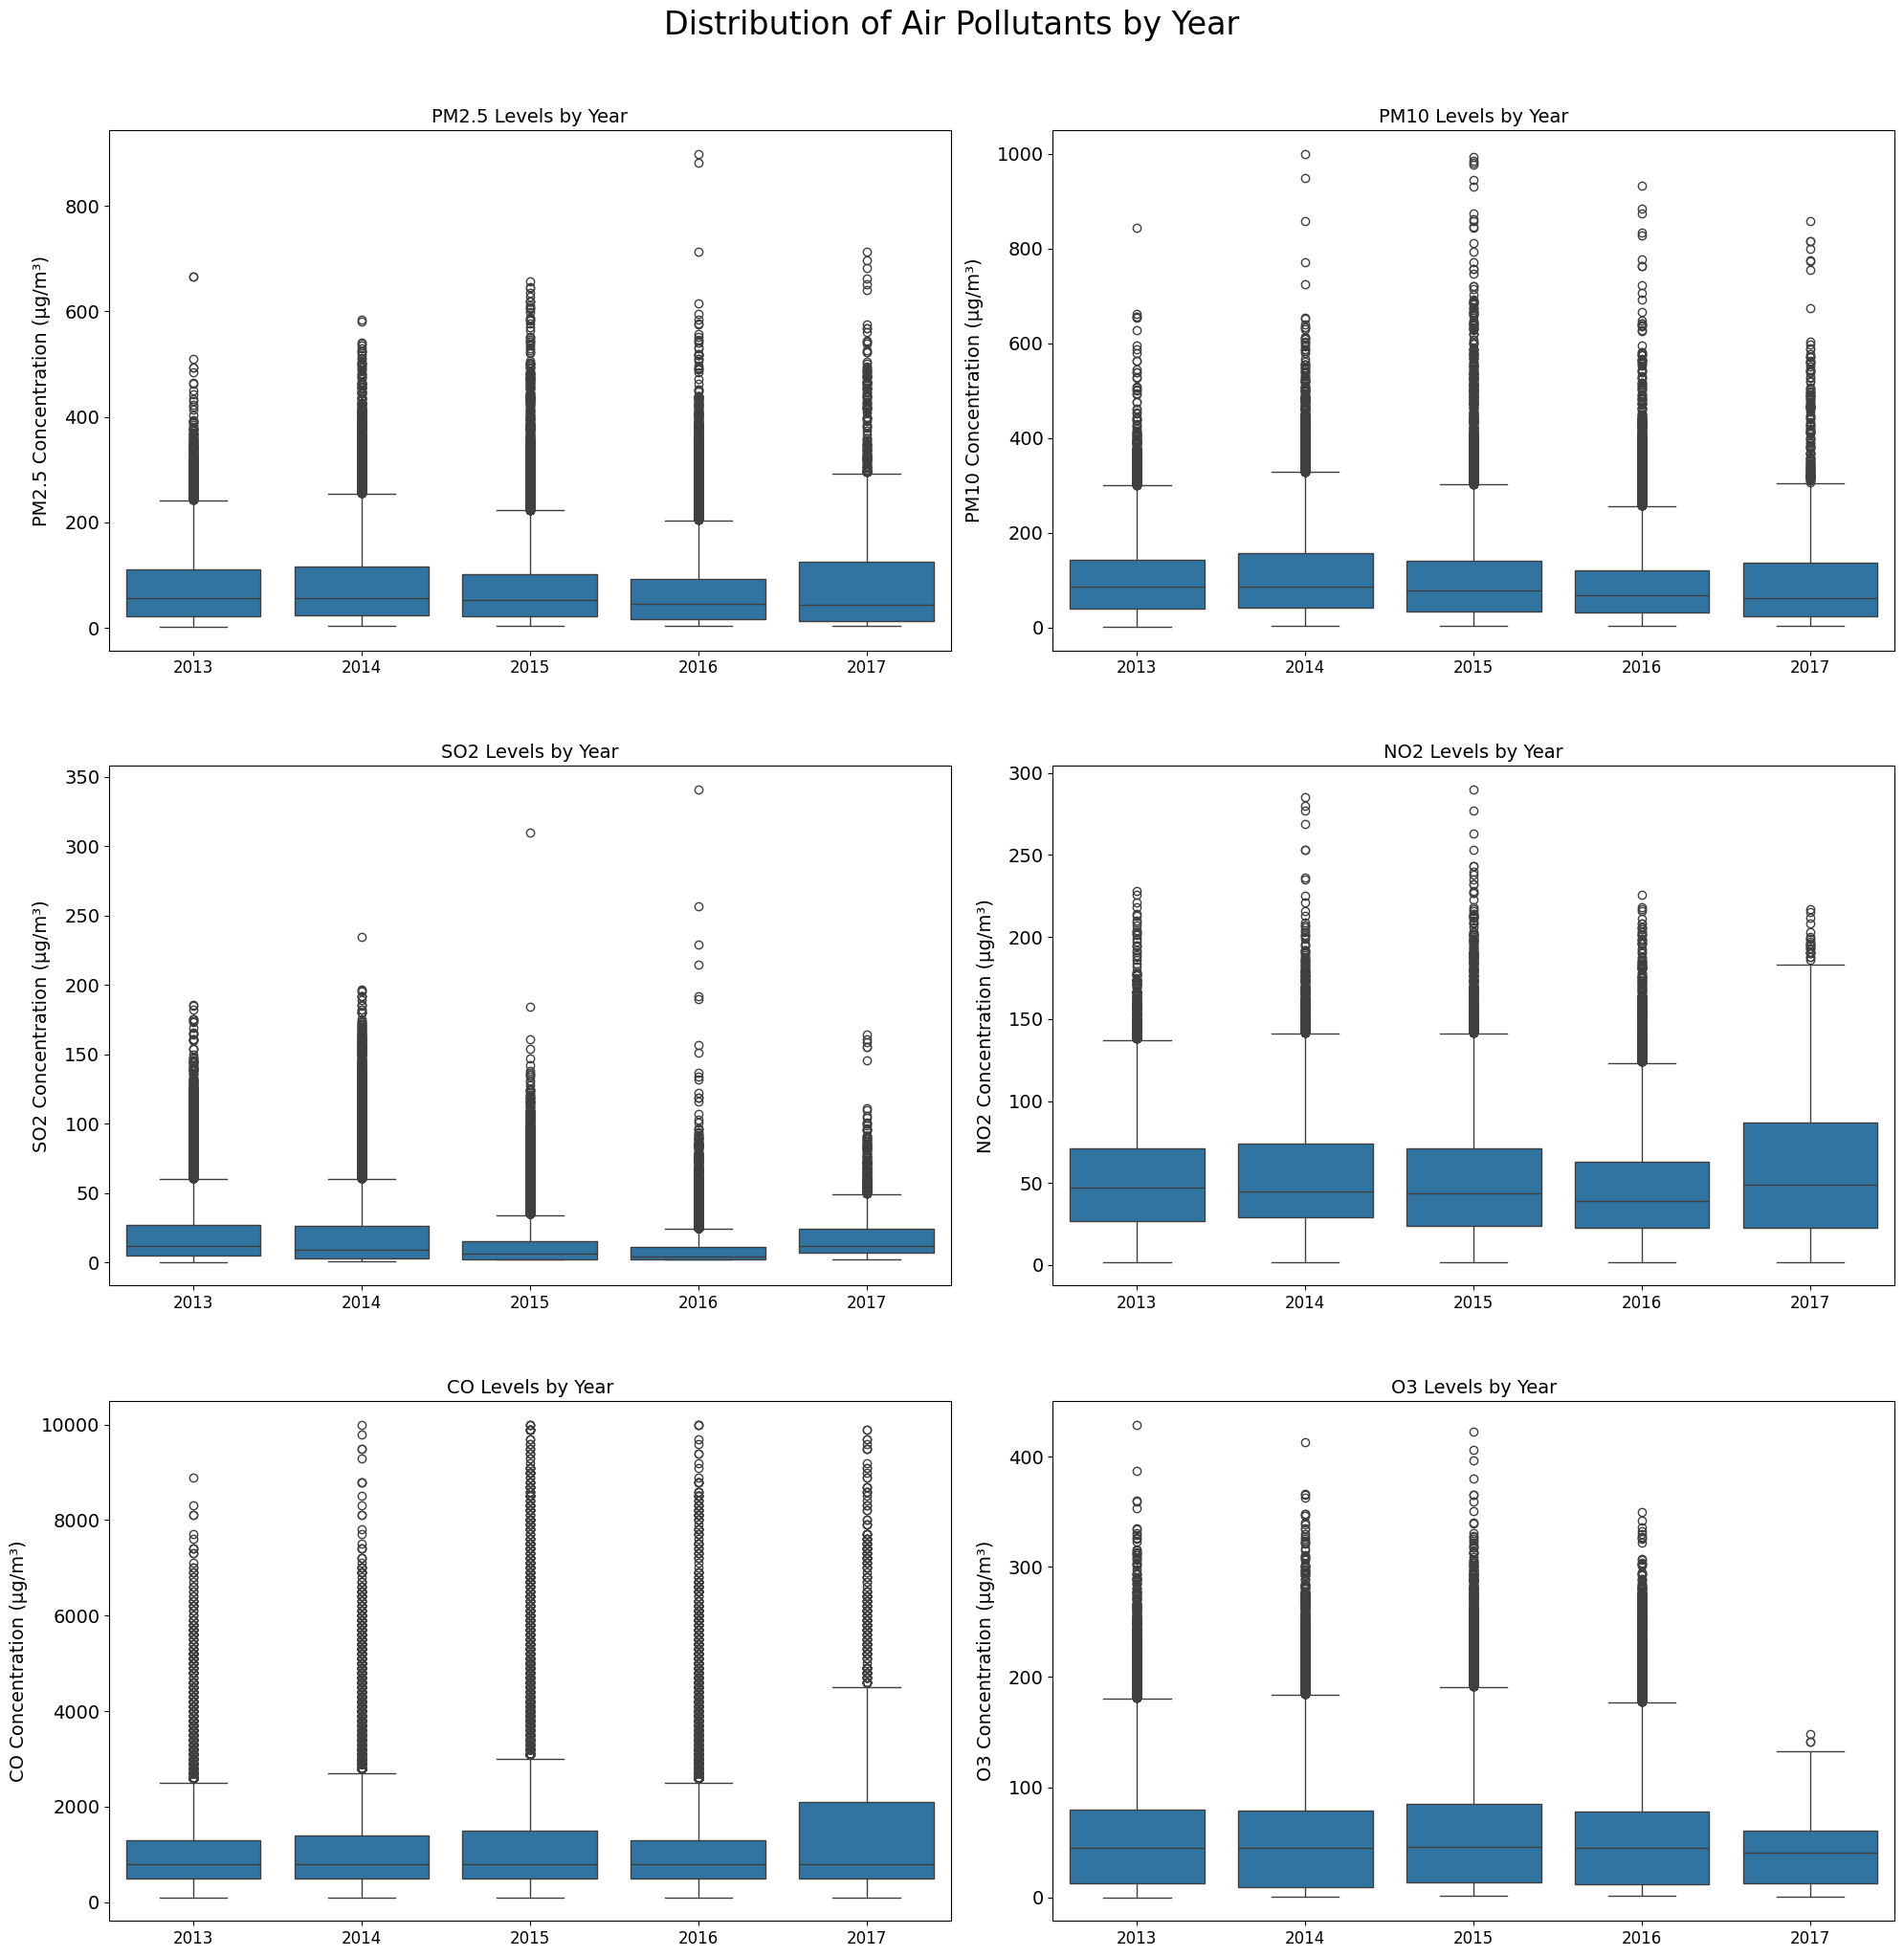

In [71]:
plt.figure(figsize=(20, 20))

for i, pollutant in enumerate(parameters):
    plt.subplot(3, 2, i + 1)  
    
    sns.boxplot(x='year', y=pollutant, data=filtered_df)
    
    plt.title(f'{pollutant} Levels by Year', fontsize=14)
    plt.ylabel(f'{pollutant} Concentration (µg/m³)', fontsize=14, labelpad=10)
    plt.xlabel('')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)

plt.suptitle('Distribution of Air Pollutants by Year', fontsize=24, y=1.02)

plt.tight_layout(h_pad=5)
plt.show()


## 3. Summary Statistics

In [77]:
filtered_df[filtered_df.station=='Aotizhongxin'][parameters].describe()

PM2.5          PM10           SO2           NO2            CO            O3
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000
mean      81.961793    109.424373     17.125888     58.859282   1239.496863     55.796764
std       81.194965     94.345610     22.567267     36.661350   1194.422306     56.531959
min        3.000000      2.000000      0.285600      2.000000    100.000000      0.214200
25%       23.000000     39.000000      3.000000     31.000000    500.000000      9.000000
50%       56.000000     84.000000      8.000000     52.000000    800.000000     45.000000
75%      112.000000    153.000000     21.000000     81.000000   1500.000000     80.000000
max      898.000000    984.000000    341.000000    290.000000  10000.000000    423.000000

In [98]:
filtered_df[filtered_df.station=='Changping'][parameters].describe()

PM2.5          PM10           SO2           NO2            CO            O3
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000
mean      70.678137     94.397978     14.834271     44.178622   1137.019279     57.717103
std       71.579210     82.770507     20.807121     29.237683   1081.250627     53.873125
min        2.000000      2.000000      0.285600      1.847700    100.000000      0.214200
25%       18.000000     34.000000      2.000000     22.000000    500.000000     16.000000
50%       48.000000     74.000000      7.000000     37.000000    800.000000     45.000000
75%       98.000000    129.000000     18.000000     60.000000   1400.000000     79.000000
max      882.000000    999.000000    310.000000    226.000000  10000.000000    429.000000

## 4. Time Series Plots

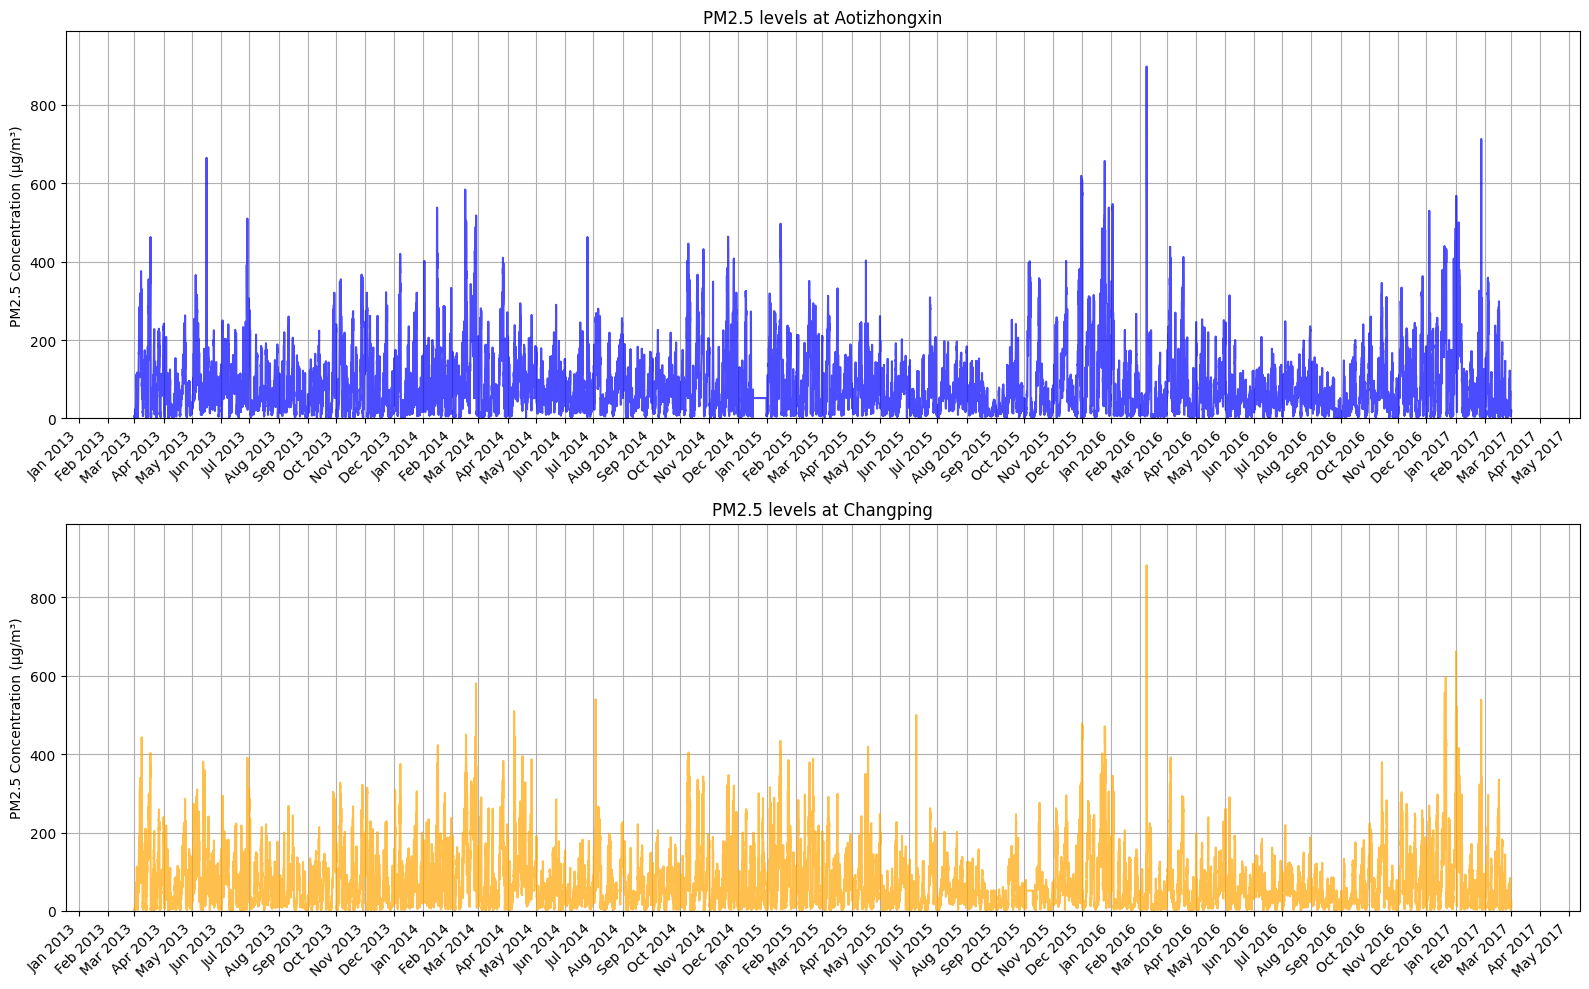

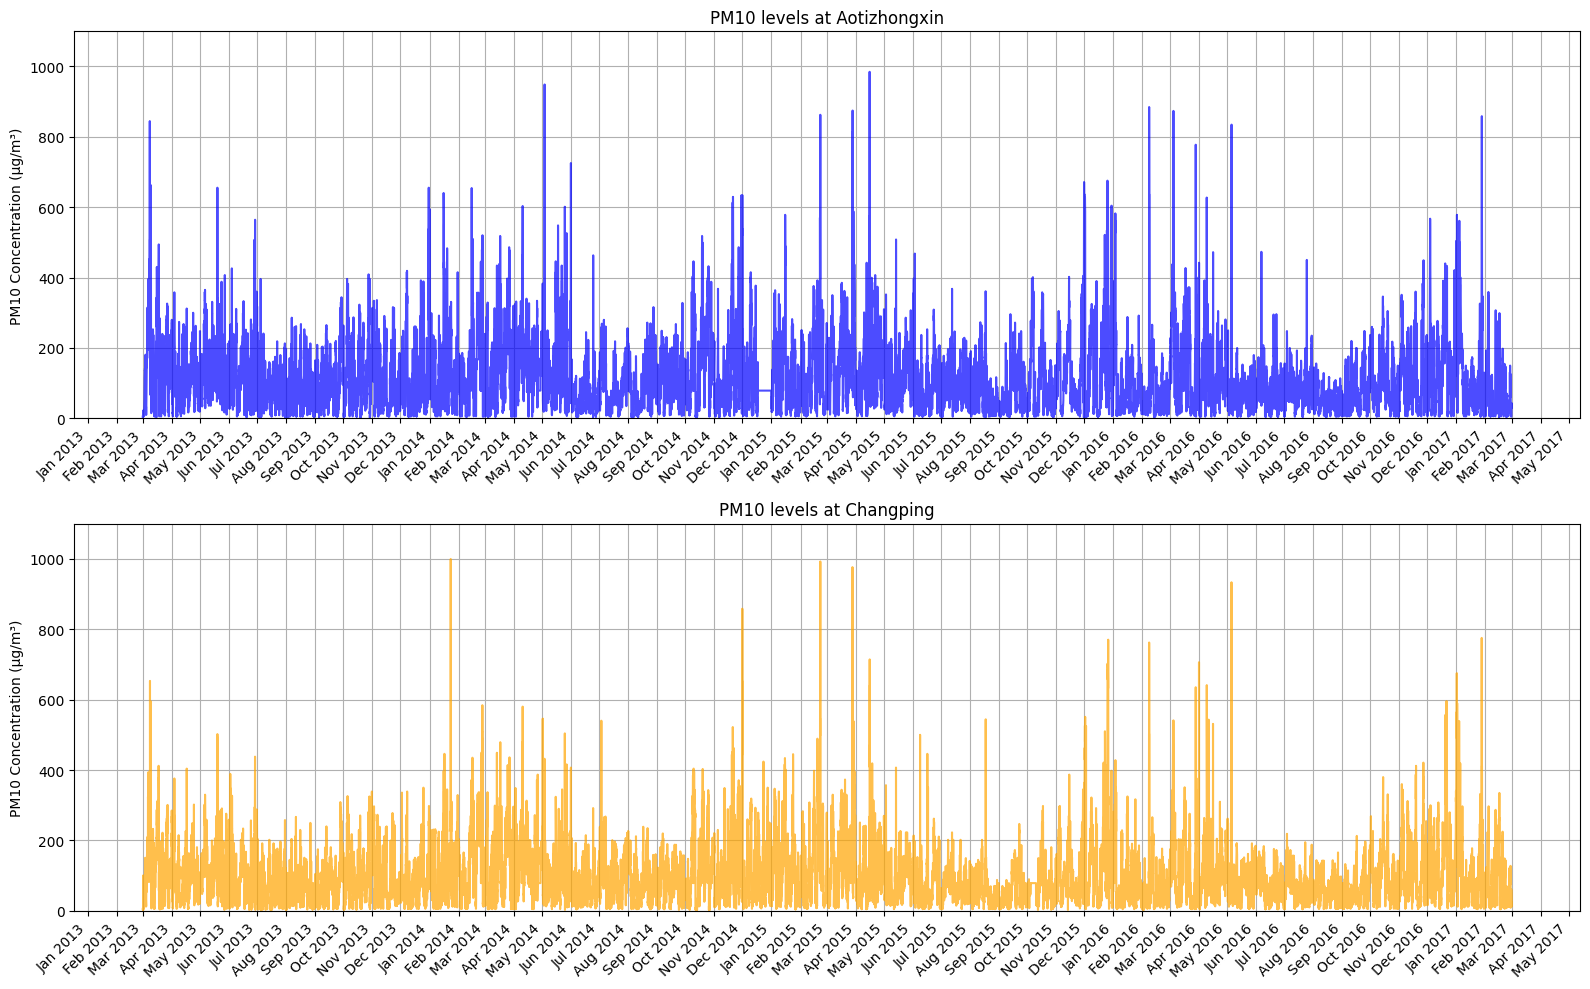

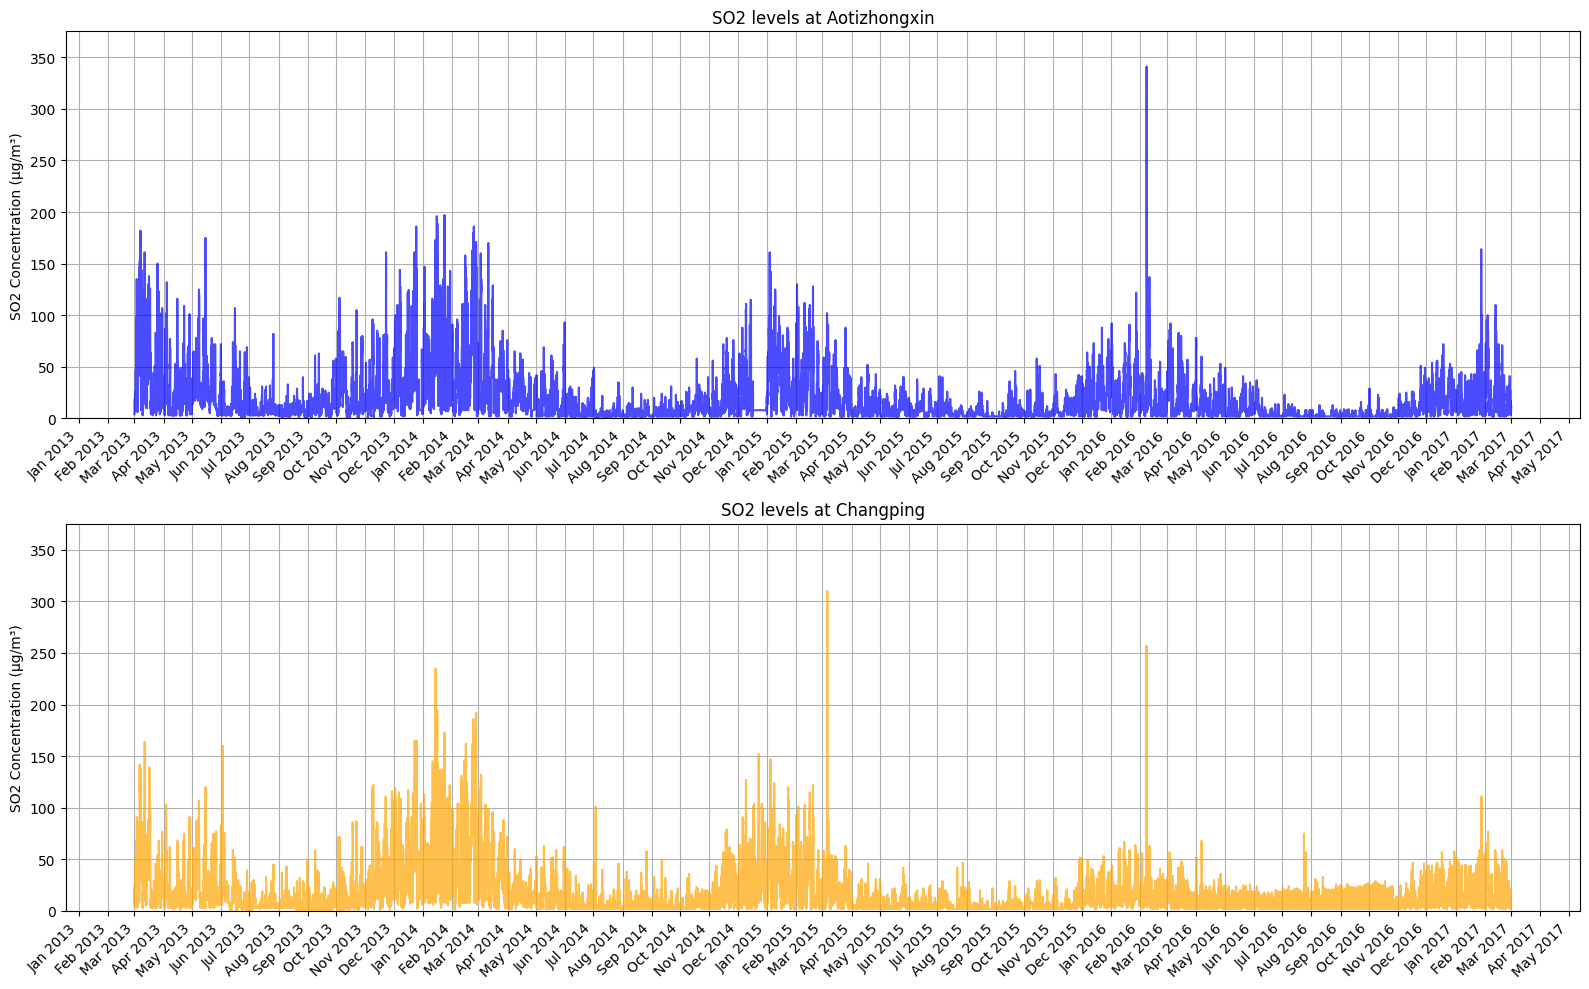

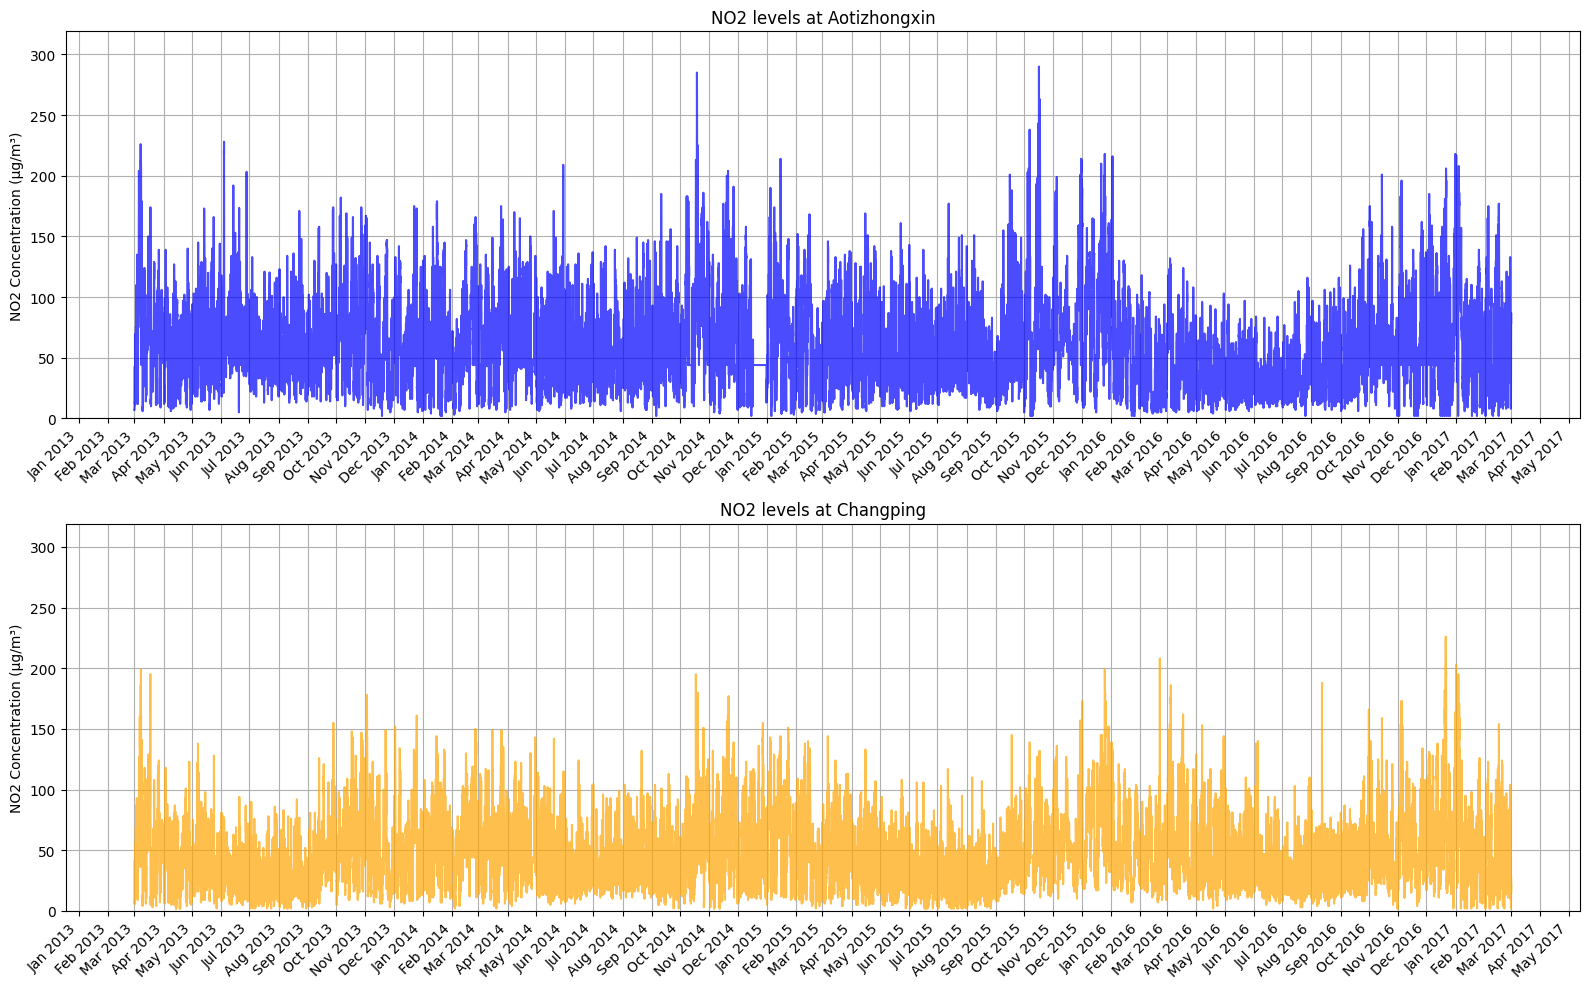

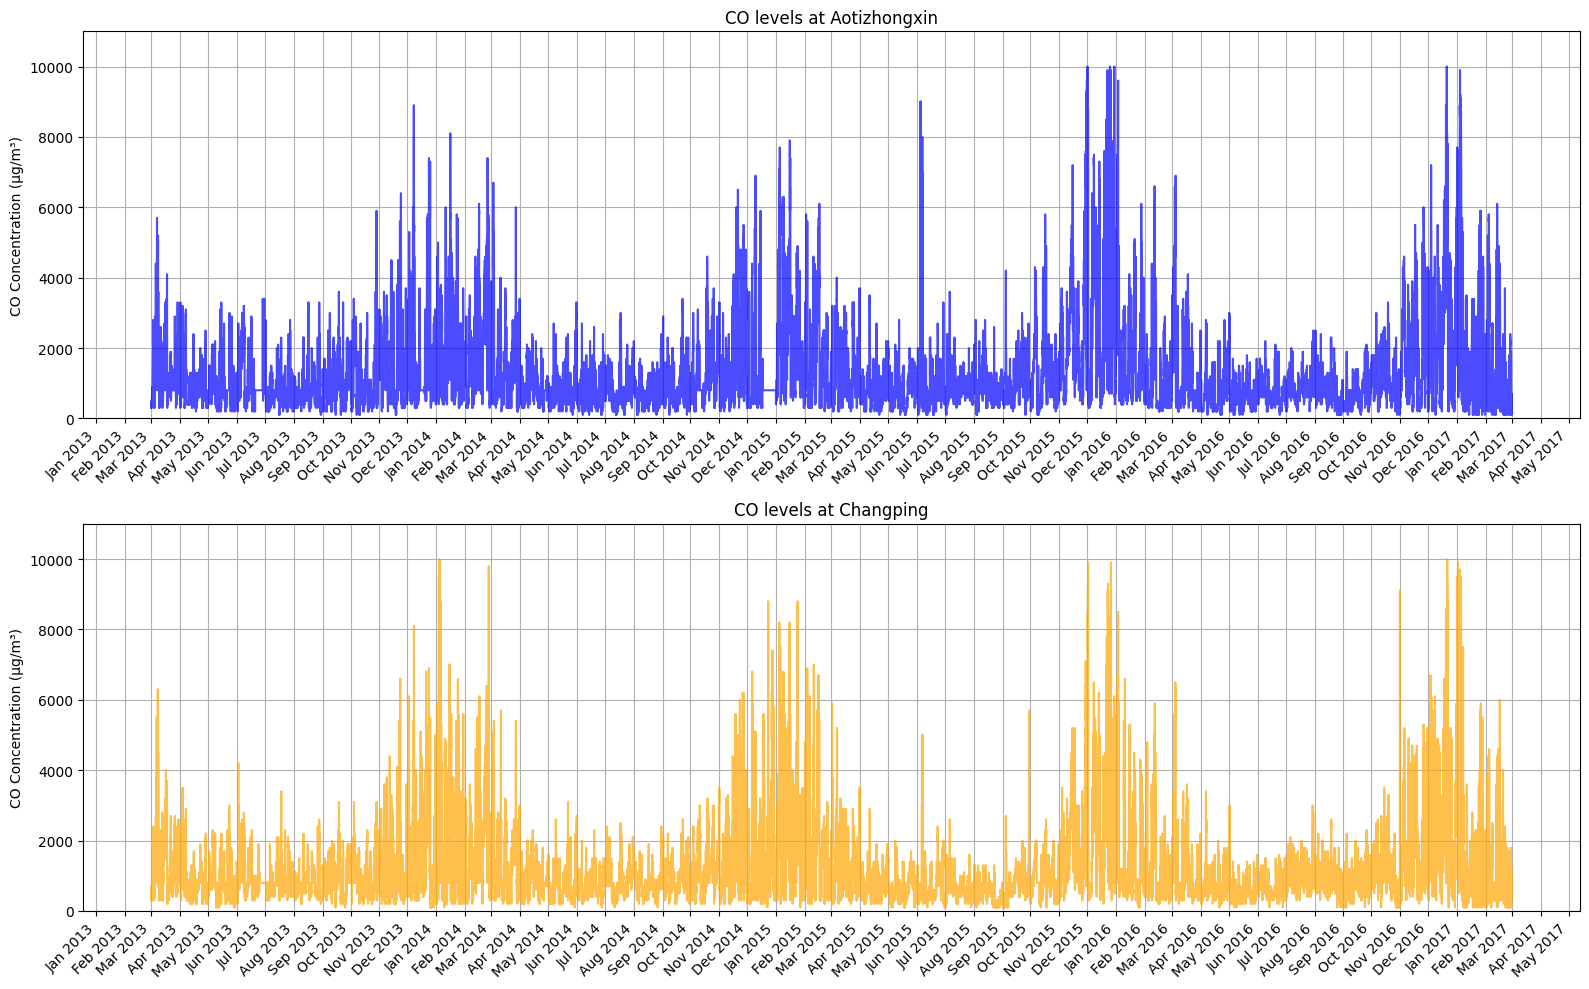

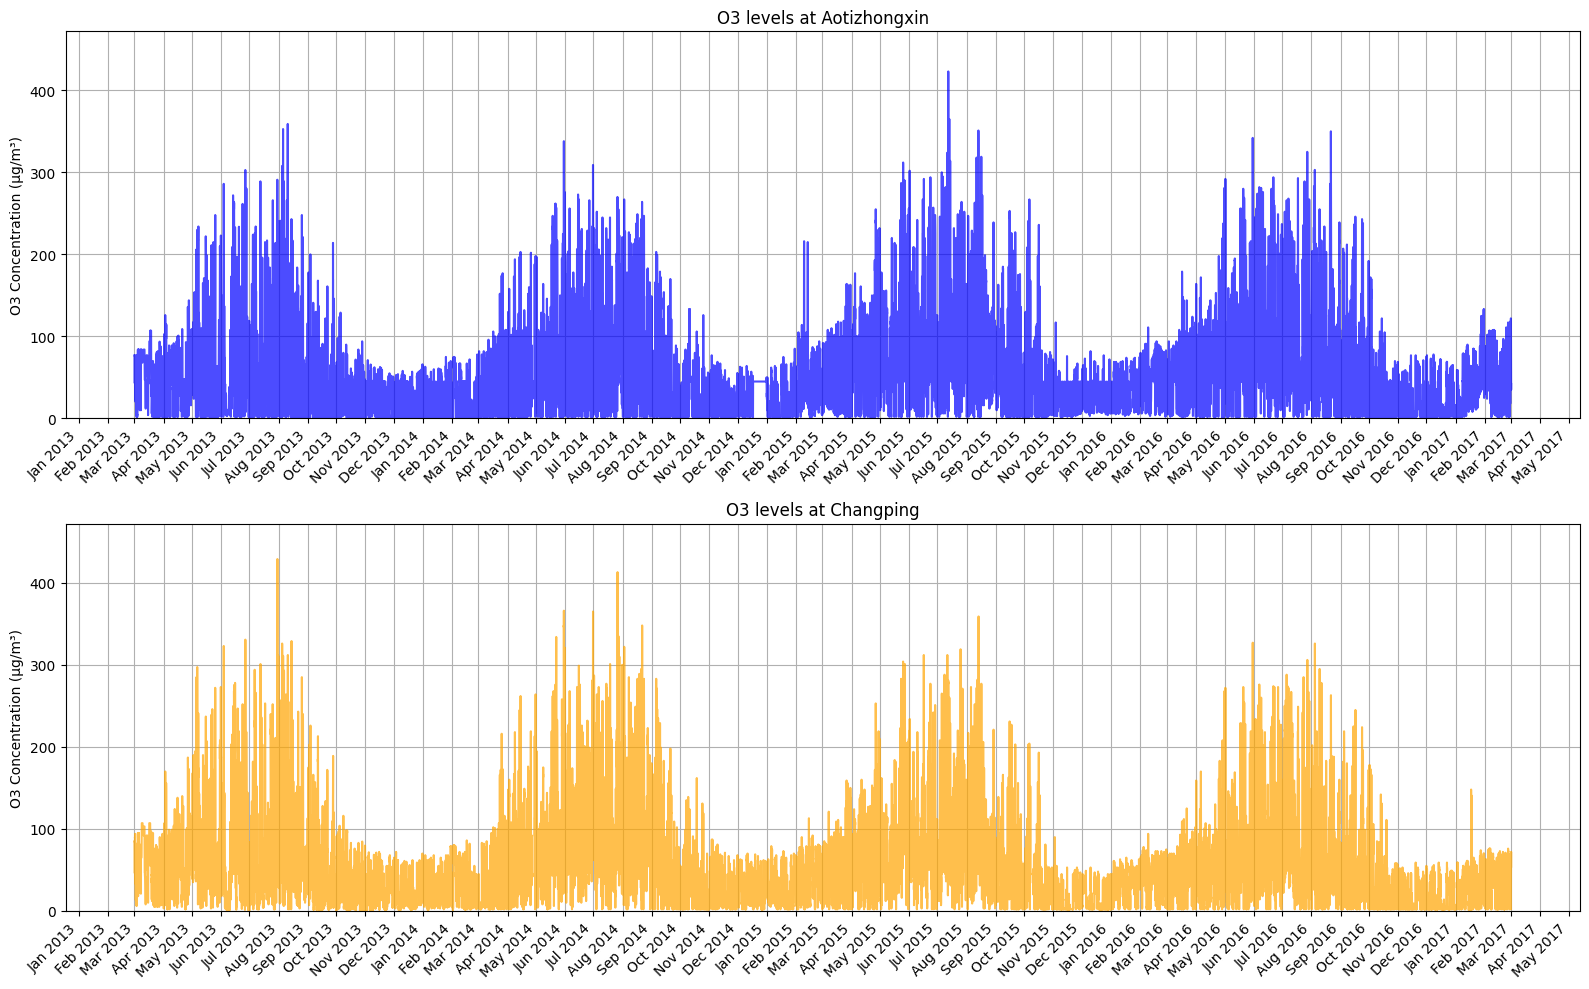

In [106]:
stations = filtered_df['station'].unique()
colors = {stations[0]: 'blue', stations[1]: 'orange'}

def plot_parameter(parameter):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))  
    
    # Find the global maximum for the y-axis limit (for comparison)
    global_max = filtered_df[parameter].max()
    
    for j, station in enumerate(stations):
        station_data = filtered_df[filtered_df['station'] == station]
        
        # Plotting
        axes[j].plot(station_data['timestamp'], station_data[parameter], 
                     color=colors[station], alpha=0.7, label=station)
        
        axes[j].set_title(f'{parameter} levels at {station}')
        axes[j].grid()
        
        # Set y-axis to be the same for both stations (using the max value)
        axes[j].set_ylim(0, global_max * 1.1)  # Adding 10% buffer for better visualization
        
        # Set x-ticks for each subplot
        x_ticks = mdates.MonthLocator(interval=1)  # Ticks every month
        x_formatter = mdates.DateFormatter('%b %Y')  # Format as 'Month Year'
        
        axes[j].xaxis.set_major_locator(x_ticks)
        axes[j].xaxis.set_major_formatter(x_formatter)
        plt.setp(axes[j].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        axes[j].set_xlabel('')  
        axes[j].set_ylabel(f'{parameter} Concentration (µg/m³)')

    plt.tight_layout()
    plt.show()

for parameter in parameters:
    plot_parameter(parameter)

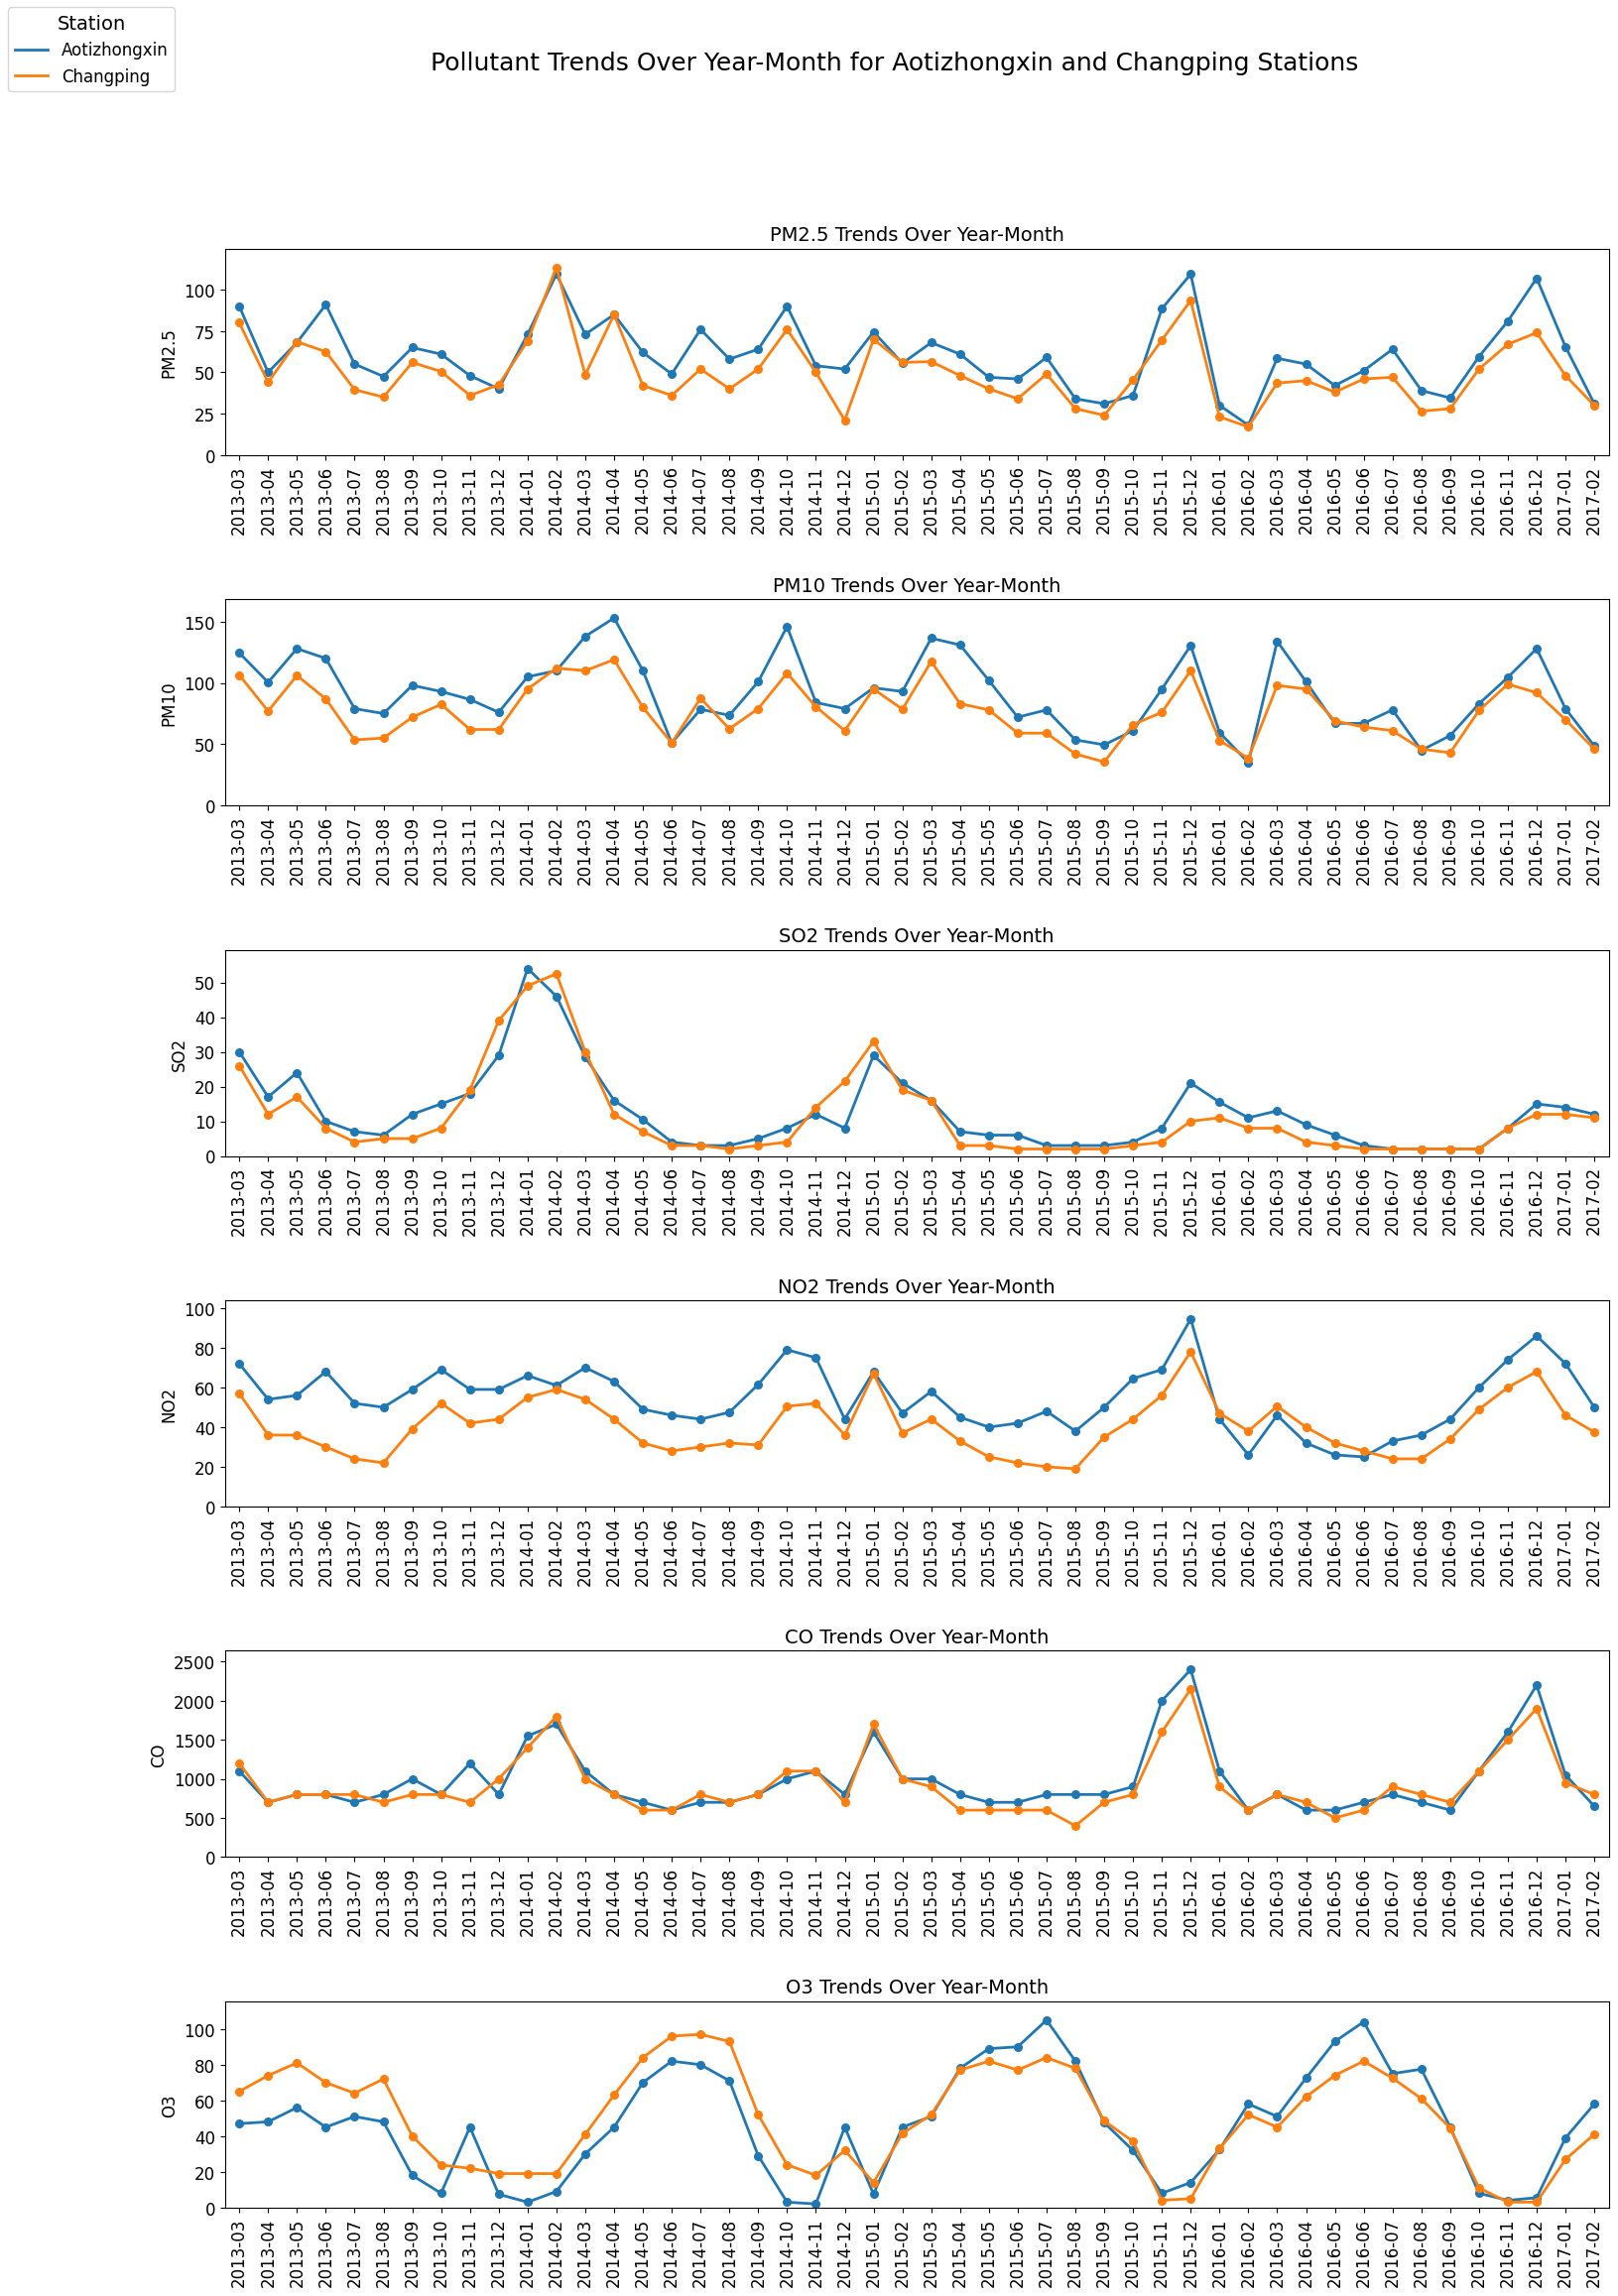

In [191]:
median_df = filtered_df.groupby(['year', 'month', 'station'])[parameters].median().reset_index()

# Create a new column 'year-month' for easier plotting
median_df['year_month'] = median_df['year'].astype(str) + '-' + median_df['month'].astype(str).str.zfill(2)

fig, axes = plt.subplots(len(parameters), 1, figsize=(18, 25)) 

for i, pollutant in enumerate(parameters):
    sns.pointplot(x='year_month', y=pollutant, hue='station', data=median_df, ax=axes[i], legend=False, linewidth= 2 )
    
    axes[i].set_title(f'{pollutant} Trends Over Year-Month', fontsize=14)
    axes[i].set_ylabel(pollutant, fontsize=12)
    
    # Set the y-axis limits to start from 0 and go to 1.1 * max value
    y_max = median_df[pollutant].max()
    axes[i].set_ylim(bottom=0, top=1.1 * y_max)
    axes[i].set_xlabel('') 
    
    axes[i].tick_params(axis='x', rotation=90)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)

fig.suptitle('Pollutant Trends Over Year-Month for Aotizhongxin and Changping Stations', fontsize=18)


unique_stations = median_df['station'].unique()

handles = []
for station in unique_stations:
    # Create a line to represent each station for the legend
    handles.append(plt.Line2D([0], [0], color=sns.color_palette()[unique_stations.tolist().index(station)], lw=2))


fig.legend(handles, unique_stations, loc='upper left', fontsize=12, title='Station', title_fontsize=14)

  
plt.subplots_adjust(top=0.9, hspace=0.7) 

plt.show()


## 5. Histograms

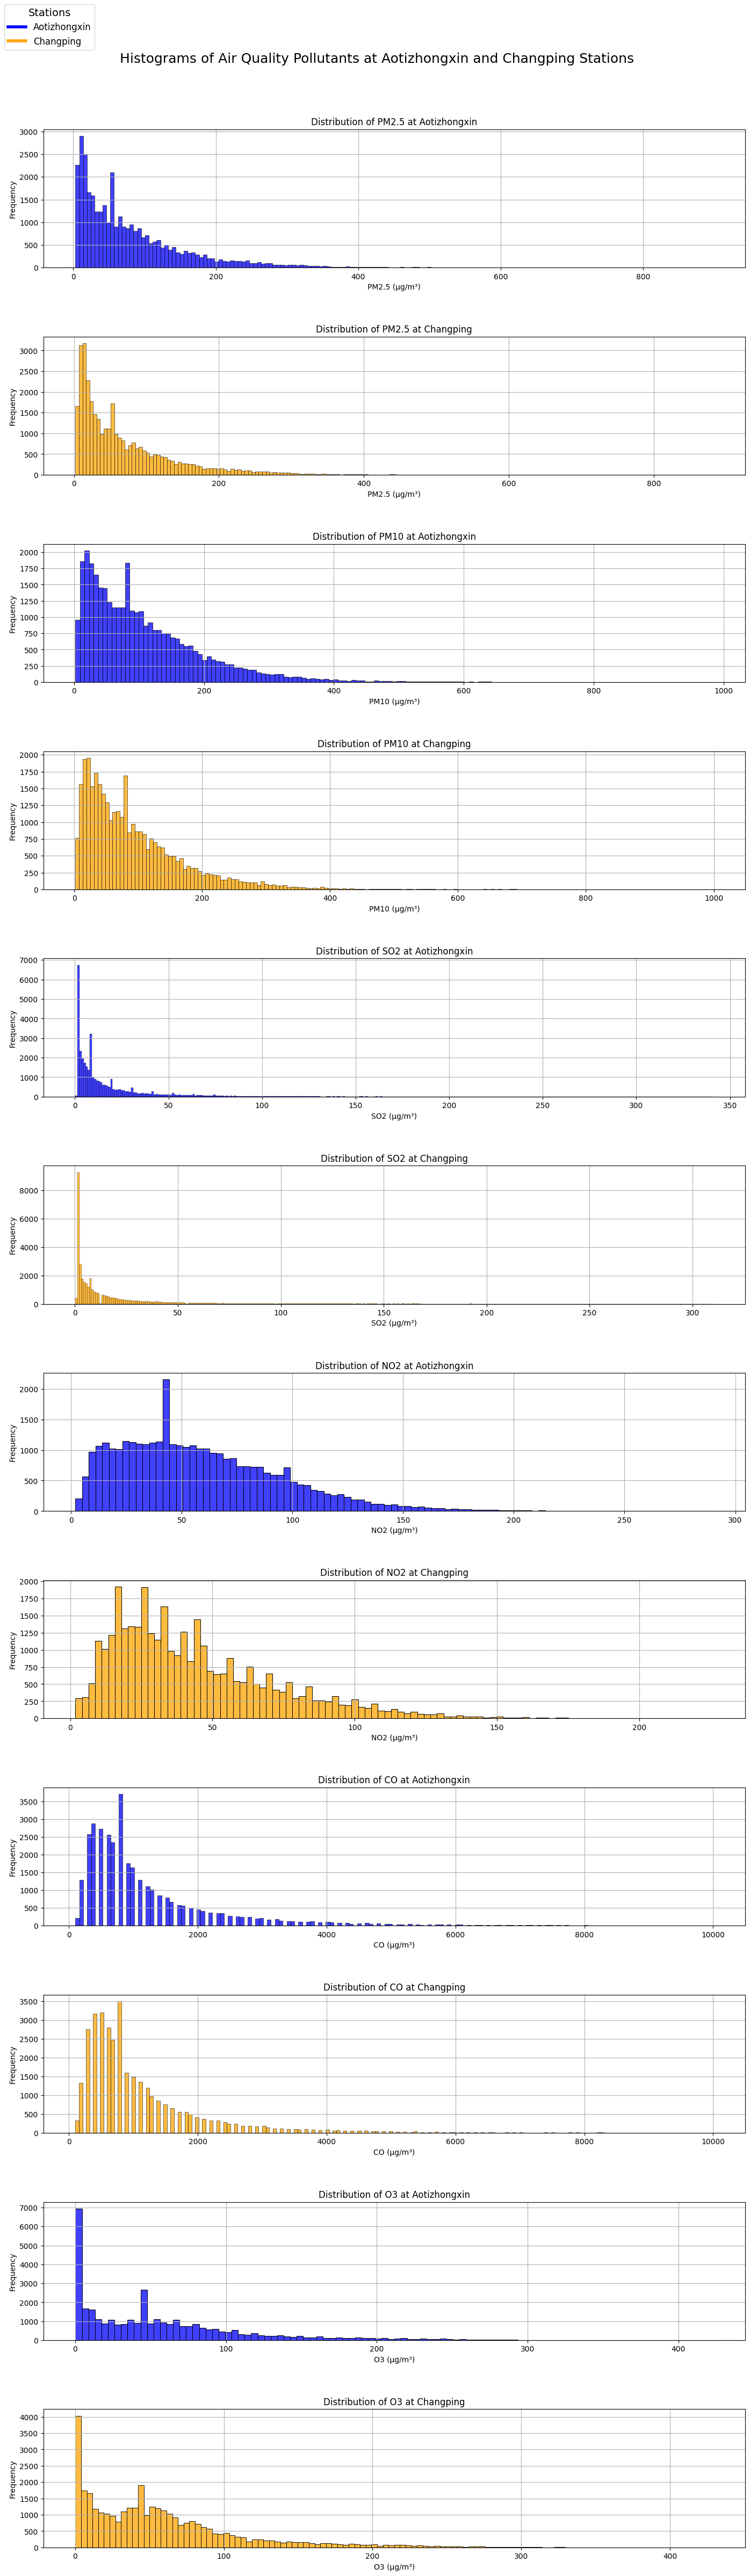

In [209]:
fig, axes = plt.subplots(len(parameters) * 2, 1, figsize=(14, 4 * len(parameters) * 2))

for i, parameter in enumerate(parameters):
    
    for j, station in enumerate(stations):
        station_data = filtered_df[filtered_df['station'] == station]
        
        sns.histplot(station_data[parameter], bins='auto', ax=axes[i * 2 + j],
                     color='blue' if station == 'Aotizhongxin' else 'orange')
        
        axes[i * 2 + j].set_title(f'Distribution of {parameter} at {station}')
        axes[i * 2 + j].set_xlabel(f'{parameter} (µg/m³)')  
        axes[i * 2 + j].set_ylabel('Frequency')
        axes[i * 2 + j].grid(True)
        
        
    
    
    
fig.suptitle('Histograms of Air Quality Pollutants at Aotizhongxin and Changping Stations', fontsize=18)
handles = [plt.Line2D([0], [0], color=colors[station], lw=4) for station in stations]
fig.legend(handles, stations, loc='upper left', fontsize=12, title='Stations', title_fontsize=14)



plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.5) 

plt.show()

## 6. Correlation Analysis

In [317]:
def correlation_analysis(station_data, parameters):

    correlation_matrix = station_data[parameters].corr(method='pearson')
    
    conf_intervals_lower = pd.DataFrame(index=parameters, columns=parameters)
    conf_intervals_upper = pd.DataFrame(index=parameters, columns=parameters)
    spearman_corr_matrix = pd.DataFrame(index=parameters, columns=parameters)

    for i in parameters:
        for j in parameters:
            if i != j:
                # Pearson correlation and confidence interval calculation
                corr_coef, _ = stats.pearsonr(station_data[i], station_data[j])
                
                # Fisher transformation for confidence intervals
                fisher_z = np.arctanh(corr_coef)
                std_error = 1 / np.sqrt(station_data[i].size - 3)
                z_conf_interval = stats.norm.ppf(0.975) * std_error
                
                lower_bound = np.tanh(fisher_z - z_conf_interval)
                upper_bound = np.tanh(fisher_z + z_conf_interval)
                
                conf_intervals_lower.loc[i, j] = lower_bound
                conf_intervals_upper.loc[i, j] = upper_bound
                
                # Spearman correlation coefficient
                spearman_corr, _ = stats.spearmanr(station_data[i], station_data[j])
                spearman_corr_matrix.loc[i, j] = spearman_corr
            else:
                conf_intervals_lower.loc[i, j] = None
                conf_intervals_upper.loc[i, j] = None
                spearman_corr_matrix.loc[i, j] = 1.0  

    return correlation_matrix, conf_intervals_lower, conf_intervals_upper, spearman_corr_matrix

In [319]:
def visualize_correlation_matrix(correlation_matrix, station):
    
    correlation_matrix = correlation_matrix.astype(float)
    # Mask for the upper triangle (exclude the diagonal)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

    # Create the heatmap
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm',  
                mask=mask,  
                cbar_kws={"shrink": 1}, 
                linewidths=0.5, 
                linecolor='white',  
                square=True,  
                vmax=1, 
                vmin=-1)  

    plt.title(f'Correlation Matrix for {station}', pad=30)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    plt.show()

#### Aotizhongxin Station

In [318]:
station_A = stations[0]
correlation_matrix_A, conf_lower_A, conf_upper_A, spearman_corr_A = correlation_analysis(
    filtered_df[filtered_df.station == station_A], parameters
)

#Results for Aotizhongxin
print("Pearson Correlation Matrix:\n", correlation_matrix_A)
print("\n95% Confidence Intervals (Lower Bounds):\n", conf_lower_A)
print("\n95% Confidence Intervals (Upper Bounds):\n", conf_upper_A)
print("\nSpearman Correlation Matrix:\n", spearman_corr_A)

Pearson Correlation Matrix:
           PM2.5      PM10       SO2       NO2        CO        O3
PM2.5  1.000000  0.873792  0.477797  0.676940  0.752530 -0.158324
PM10   0.873792  1.000000  0.465419  0.647106  0.654749 -0.137282
SO2    0.477797  0.465419  1.000000  0.431587  0.528280 -0.195531
NO2    0.676940  0.647106  0.431587  1.000000  0.672922 -0.489528
CO     0.752530  0.654749  0.528280  0.672922  1.000000 -0.316873
O3    -0.158324 -0.137282 -0.195531 -0.489528 -0.316873  1.000000

95% Confidence Intervals (Lower Bounds):
           PM2.5      PM10       SO2       NO2        CO        O3
PM2.5      None  0.871294  0.469679  0.671229  0.747954 -0.168512
PM10   0.871294      None   0.45718   0.64098  0.648727 -0.147537
SO2    0.469679   0.45718      None  0.423031  0.520692 -0.205577
NO2    0.671229   0.64098  0.423031      None  0.667155 -0.497446
CO     0.747954  0.648727  0.520692  0.667155      None -0.326258
O3    -0.168512 -0.147537 -0.205577 -0.497446 -0.326258      None

95%

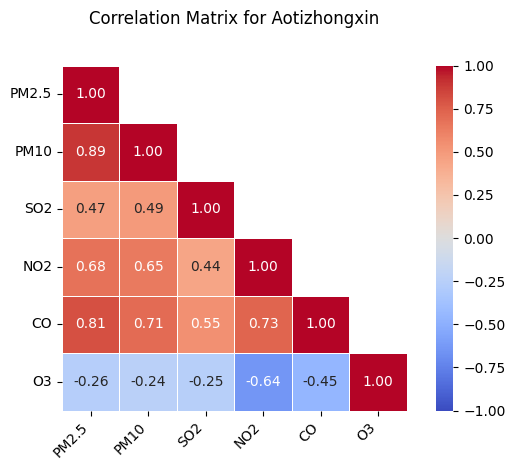

In [322]:
visualize_correlation_matrix(spearman_corr_A, station_A)

#### Changping Station

In [323]:
station_B = stations[1]
correlation_matrix_B, conf_lower_B, conf_upper_B, spearman_corr_B = correlation_analysis(
    filtered_df[filtered_df.station == station_B], parameters
)

#Results for Aotizhongxin
print("Pearson Correlation Matrix:\n", correlation_matrix_B)
print("\n95% Confidence Intervals (Lower Bounds):\n", conf_lower_B)
print("\n95% Confidence Intervals (Upper Bounds):\n", conf_upper_B)
print("\nSpearman Correlation Matrix:\n", spearman_corr_B)

Pearson Correlation Matrix:
           PM2.5      PM10       SO2       NO2        CO        O3
PM2.5  1.000000  0.857973  0.452676  0.668465  0.737815 -0.097685
PM10   0.857973  1.000000  0.419772  0.630990  0.655608 -0.049731
SO2    0.452676  0.419772  1.000000  0.489400  0.519855 -0.186761
NO2    0.668465  0.630990  0.489400  1.000000  0.719173 -0.466800
CO     0.737815  0.655608  0.519855  0.719173  1.000000 -0.301360
O3    -0.097685 -0.049731 -0.186761 -0.466800 -0.301360  1.000000

95% Confidence Intervals (Lower Bounds):
           PM2.5      PM10       SO2       NO2        CO        O3
PM2.5      None  0.855186  0.444315  0.662634  0.733009 -0.108041
PM10   0.855186      None  0.411112  0.624649  0.649598 -0.060166
SO2    0.444315  0.411112      None  0.481399  0.512175 -0.196843
NO2    0.662634  0.624649  0.481399      None  0.714081 -0.474946
CO     0.733009  0.649598  0.512175  0.714081      None -0.310847
O3    -0.108041 -0.060166 -0.196843 -0.474946 -0.310847      None

95%

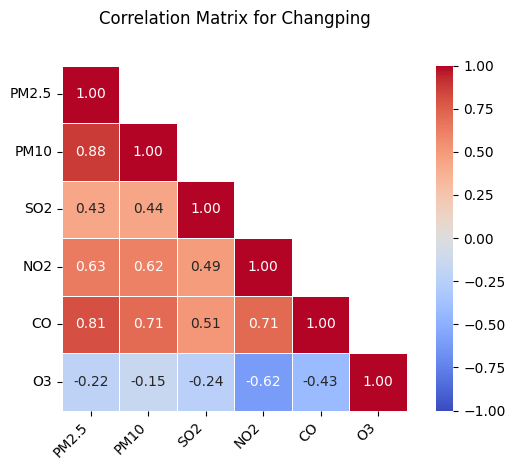

In [324]:
visualize_correlation_matrix(spearman_corr_B, station_B)

In [325]:
def correlation_analysis_and_visualization(df, station1, station2, parameters):
    
    corr_coeffs = {}
    conf_intervals = {}
    spearman_corrs = {}

    for parameter in parameters:
        # Filter data for each station
        data_station1 = df[df['station'] == station1][parameter]
        data_station2 = df[df['station'] == station2][parameter]

        # Calculate Pearson correlation coefficient
        correlation_coefficient, _ = stats.pearsonr(data_station1, data_station2)
        corr_coeffs[parameter] = correlation_coefficient

        # Fisher transformation for confidence intervals
        fisher_z = np.arctanh(correlation_coefficient)
        std_error = 1 / np.sqrt(data_station1.size - 3)
        z_conf_interval = stats.norm.ppf(0.975) * std_error
        lower_bound = np.tanh(fisher_z - z_conf_interval)
        upper_bound = np.tanh(fisher_z + z_conf_interval)
        conf_intervals[parameter] = (lower_bound, upper_bound)

        # Calculating Spearman correlation coefficient
        spearman_corr, _ = stats.spearmanr(data_station1, data_station2)
        spearman_corrs[parameter] = spearman_corr

    
    corr_df = pd.DataFrame.from_dict(corr_coeffs, orient='index', columns=['Pearson Correlation Coefficient'])
    conf_df = pd.DataFrame.from_dict(conf_intervals, orient='index', columns=['95% CI Lower Bound', '95% CI Upper Bound'])
    spearman_df = pd.DataFrame.from_dict(spearman_corrs, orient='index', columns=['Spearman Correlation Coefficient'])
    result_df = pd.concat([corr_df, conf_df, spearman_df], axis=1)
    print(result_df)

    
correlation_analysis_and_visualization(filtered_df, station_A, station_B, parameters)

       Pearson Correlation Coefficient  95% CI Lower Bound  95% CI Upper Bound  Spearman Correlation Coefficient
PM2.5                         0.835166            0.831972            0.838304                          0.853483
PM10                          0.796250            0.792387            0.800049                          0.803343
SO2                           0.796430            0.792570            0.800226                          0.779045
NO2                           0.644885            0.638730            0.650958                          0.627448
CO                            0.734179            0.729317            0.738967                          0.766015
O3                            0.859645            0.856888            0.862353                          0.779883


## Trend Analysis

## Reporting